In [1]:
import os
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import pandas as pd

# ========== HELPER FUNCTIONS (same as before) ==========

def parse_c_contents(c_contents):
    """
    Parses the OpenFOAM cell centers from a given 'c_contents' string.
    Expects the string to contain an 'internalField' entry.
    """
    lines = c_contents.split("\n")
    start_idx = None
    num_centres = None
    
    for i, line in enumerate(lines):
        if "internalField" in line:
            num_centres = int(lines[i+1].strip())
            start_idx = i + 3
            break

    if start_idx is None or num_centres is None:
        raise ValueError("Could not find 'internalField' or the number of cell centres in the content")

    coordinates = []
    for line in lines[start_idx:start_idx + num_centres]:
        if "(" in line and ")" in line:
            x, y, _ = map(float, line.strip("()\n").split())
            coordinates.append([x, y])

    return np.array(coordinates)


import numpy as np
import os
from scipy.ndimage import distance_transform_edt

def reshape_trajectory_data(sim_data, cell_centers, grid_shape):
    """
    Reshape simulation data (timesteps, num_cells, 5) to a fixed grid of shape
      (timesteps, n_rows, n_cols, 9).

    Input sim_data channels:
      0: Uₓ
      1: U_y
      2: p (pressure)
      3: Reynolds number

    Output grid channels:
      0: Uₓ
      1: U_y
      2: p (pressure)
      3: Reynolds number
      4: Binary mask (1 if fluid domain; 0 if hole)
      5: SDF (signed distance: positive in fluid, negative in hole)
    """
    n_rows, n_cols = grid_shape
    T = sim_data.shape[0]

    # Determine domain boundaries from the cell centers.
    x_min, x_max = np.min(cell_centers[:, 0]), np.max(cell_centers[:, 0])
    y_min, y_max = np.min(cell_centers[:, 1]), np.max(cell_centers[:, 1])

    # Allocate output array with 6 channels.
    reshaped = np.zeros((T, n_rows, n_cols, 6), dtype=np.float32)

    # 2) Create the binary hole mask.
    # Initialize with zeros (assume hole) then mark fluid cells with 1.
    mask = np.ones((n_rows, n_cols), dtype=np.float32)
    mapping = []
    for (x, y) in cell_centers:
        col = int(round((x - x_min) / (x_max - x_min) * (n_cols - 1)))
        row = int(round((y - y_min) / (y_max - y_min) * (n_rows - 1)))
        mapping.append((row, col))
        mask[row, col] = 0  # Mark fluid domain

    # 3) Compute the signed distance function (SDF) on the grid.
    # Use distance_transform_edt on the mask and its inverse.
    dist_fluid = distance_transform_edt(mask)       # Distance for fluid cells
    dist_hole  = distance_transform_edt(1 - mask)     # Distance for hole cells
    sdf = dist_fluid - dist_hole  # SDF: positive in fluid, negative in hole

    # 4) Fill the simulation data into channels 0-4.
    # For each time step, place the 5 channels from sim_data into the grid.
    for t in range(T):
        for i, (row, col) in enumerate(mapping):
            reshaped[t, row, col, 0:4] = sim_data[t, i, :]

    # 5) Set the binary mask channel (channel 5) and SDF channel (channel 6) for every time step.
    for t in range(T):
        reshaped[t, :, :, 4] = mask
        reshaped[t, :, :, 5] = sdf

    return reshaped


def combine_and_reshape_trajectories(dataset, sim_data_list, grid_shape, save_folder, file_name="combined.npy"):
    """
    Combines and reshapes trajectory data from multiple simulations.

    Parameters:
      dataset: np.ndarray of shape (num_trajectories, timesteps, num_cells, 4)
               (4 channels: [Uₓ, U_y, p, Reynolds number])
      sim_data_list: list of dicts, each with keys "folder" and "c_contents"
      grid_shape: tuple (n_rows, n_cols) defining the target grid dimensions.
      save_folder: directory where the combined .npy file will be saved.
      file_name: name of the output .npy file (default "combined.npy").

    Returns:
      combined: np.ndarray of shape (num_trajectories, timesteps, n_rows, n_cols, 6)
      with channels:
          0: Uₓ
          1: U_y
          2: p
          3: Reynolds number
          4: Binary mask (hole indicator)
          5: SDF (signed distance function)
    """
    from tqdm import tqdm
    import gc

    num_trajectories = dataset.shape[0]
    if num_trajectories != len(sim_data_list):
        raise ValueError(f"Number of simulations in .npy ({num_trajectories}) does not match the number of JSON entries ({len(sim_data_list)}).")

    combined_list = []
    
    for i in tqdm(range(num_trajectories), desc="Reshaping Trajectories"):
        sim_data = dataset[i]  # (timesteps, num_cells, 5)
        entry = sim_data_list[i]
        
        folder_name = entry["folder"]
        c_contents = entry["c_contents"]
        
        # Parse the cell centers from the c_contents.
        cell_centers = parse_c_contents(c_contents)
        reshaped_data = reshape_trajectory_data(sim_data, cell_centers, grid_shape)
        combined_list.append(reshaped_data)
        gc.collect()
        
    combined = np.array(combined_list, dtype=np.float32)
    os.makedirs(save_folder, exist_ok=True)
    save_path = os.path.join(save_folder, file_name)
    np.save(save_path, combined)
    print(f"Saved combined trajectory data at: {save_path}")
    return combined

def save_grid_to_file(grid, filename):
    """
    Saves the grid values to a text file in a readable format.
    Each row corresponds to a row in the grid, making it easy to verify values.
    """
    df = pd.DataFrame(grid)
    df.to_csv(filename, sep='\t', header=False, index=False)
    print(f"Saved grid values to {filename}")

# For testing the SDF and mask extraction:
def test_sdf_and_mask_extraction():
    # Load data from the testing file (assumes output has shape (..., 128, 128, 9))
    data = np.load("testingsdf.npy")
    
    # According to our new ordering:
    # SDF is in channel 6 and geometry mask is in channel 5.
    sdf_sample = data[0, 0, :, :, 5]         # first trajectory, first timestep, SDF values
    geometry_mask_sample = data[0, 0, :, :, 4] # first trajectory, first timestep, mask values
    
    # Save extracted grids to files.
    save_grid_to_file(sdf_sample, "sdf_values_from_testingsdf.txt")
    save_grid_to_file(geometry_mask_sample, "geometry_mask_from_testingsdf.txt")

def plot_with_hole_white(
    trajectory, 
    channel_names=["Ux", "Uy", "P", "Re", "mask", "sdf"], 
    tol=1e-8
):
    """
    Plot each timestep of a trajectory such that values whose absolute value
    is below a given tolerance are displayed as white (masked).
    """
    cmap = matplotlib.cm.get_cmap('gist_ncar').copy()
    cmap.set_bad(color='white')

    n_timesteps = trajectory.shape[0]
    for t in range(n_timesteps):
        data = trajectory[t]
        n_channels = data.shape[-1]
        
        fig, axes = plt.subplots(1, n_channels, figsize=(4*n_channels, 4))
        for ch in range(n_channels):
            masked_channel = np.ma.masked_where(np.abs(data[:, :, ch]) < tol, data[:, :, ch])
            valid_vals = data[:, :, ch][np.abs(data[:, :, ch]) >= tol]
            if valid_vals.size > 0:
                vmin, vmax = valid_vals.min(), valid_vals.max()
            else:
                vmin, vmax = 0, 1
            im = axes[ch].imshow(masked_channel, cmap=cmap, vmin=vmin, vmax=vmax)
            axes[ch].set_title(f"{channel_names[ch]} | Timestep {t}")
            axes[ch].axis("off")
            fig.colorbar(im, ax=axes[ch], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

def main():
    # List of .npy files (modify this with actual file paths)
    npy_files = [
        "/data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_1.npy",
        "/data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_2.npy",
        "/data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_3.npy",
        "/data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_4.npy",
        "/data/user_data/namancho/FPO_cylinder_hole_location/2results_batch_1.npy",
    ]

    # List of corresponding .json files
    json_files = [
        "/data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_1.json",
        "/data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_2.json",
        "/data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_3.json",
        "/data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_4.json",
        "/data/user_data/namancho/FPO_cylinder_hole_location/2sim_data_batch_1.json",
    ]

    # Output folder
    output_folder = "/data/user_data/namancho/FPO_cylinder_hole_location/"
    os.makedirs(output_folder, exist_ok=True)

    # Grid size
    grid_shape = (128, 128)

    # List to store all reshaped batches
    all_batches = []

    # Loop through each pair of .npy and .json files
    for data_path, json_c_file_path in zip(npy_files, json_files):
        print(f"\nProcessing: {data_path} and {json_c_file_path}")

        # 1. Load the simulation data
        print(f"Loading simulation data from {data_path}")
        data = np.load(data_path)  
        print(f"Data shape: {data.shape}")
        n_sims = data.shape[0]

        # 2. Load the JSON file
        print(f"Loading JSON file: {json_c_file_path}")
        with open(json_c_file_path, "r") as f:
            raw_entries = json.load(f)

        print(f"Loaded JSON with {len(raw_entries)} entries total.")

        # 3. Verify data consistency
        if len(raw_entries) != n_sims:
            raise ValueError(f"Mismatch: {len(raw_entries)} JSON entries vs {n_sims} simulations.")

        # 4. Reshape the trajectories
        reshaped_data = combine_and_reshape_trajectories(data, raw_entries, grid_shape, save_folder=output_folder)
        print(f"Reshaped data shape: {reshaped_data.shape}")

        # Append to list for final concatenation
        all_batches.append(reshaped_data)

    # Concatenate all batches into one final dataset
    final_data = np.concatenate(all_batches, axis=0)
    final_save_path = os.path.join(output_folder, "final_reshaped_data.npy")
    np.save(final_save_path, final_data)

    print(f"\nFinal combined dataset saved at: {final_save_path}")
    print(f"Final shape: {final_data.shape}")


if __name__ == "__main__":
    main()



Processing: /data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_1.npy and /data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_1.json
Loading simulation data from /data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_1.npy
Data shape: (128, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_1.json
Loaded JSON with 128 entries total.


Reshaping Trajectories: 100%|██████████| 128/128 [00:26<00:00,  4.79it/s]


Saved combined trajectory data at: /data/user_data/namancho/FPO_cylinder_hole_location/combined.npy
Reshaped data shape: (128, 20, 128, 128, 6)

Processing: /data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_2.npy and /data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_2.json
Loading simulation data from /data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_2.npy
Data shape: (128, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_2.json
Loaded JSON with 128 entries total.


Reshaping Trajectories: 100%|██████████| 128/128 [00:26<00:00,  4.90it/s]


Saved combined trajectory data at: /data/user_data/namancho/FPO_cylinder_hole_location/combined.npy
Reshaped data shape: (128, 20, 128, 128, 6)

Processing: /data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_3.npy and /data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_3.json
Loading simulation data from /data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_3.npy
Data shape: (128, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_3.json
Loaded JSON with 128 entries total.


Reshaping Trajectories: 100%|██████████| 128/128 [00:26<00:00,  4.91it/s]


Saved combined trajectory data at: /data/user_data/namancho/FPO_cylinder_hole_location/combined.npy
Reshaped data shape: (128, 20, 128, 128, 6)

Processing: /data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_4.npy and /data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_4.json
Loading simulation data from /data/user_data/namancho/FPO_cylinder_hole_location/1results_batch_4.npy
Data shape: (128, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/FPO_cylinder_hole_location/sim_data_batch_4.json
Loaded JSON with 128 entries total.


Reshaping Trajectories: 100%|██████████| 128/128 [00:25<00:00,  4.94it/s]


Saved combined trajectory data at: /data/user_data/namancho/FPO_cylinder_hole_location/combined.npy
Reshaped data shape: (128, 20, 128, 128, 6)

Processing: /data/user_data/namancho/FPO_cylinder_hole_location/2results_batch_1.npy and /data/user_data/namancho/FPO_cylinder_hole_location/2sim_data_batch_1.json
Loading simulation data from /data/user_data/namancho/FPO_cylinder_hole_location/2results_batch_1.npy
Data shape: (88, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/FPO_cylinder_hole_location/2sim_data_batch_1.json
Loaded JSON with 88 entries total.


Reshaping Trajectories: 100%|██████████| 88/88 [00:17<00:00,  4.93it/s]


Saved combined trajectory data at: /data/user_data/namancho/FPO_cylinder_hole_location/combined.npy
Reshaped data shape: (88, 20, 128, 128, 6)

Final combined dataset saved at: /data/user_data/namancho/FPO_cylinder_hole_location/final_reshaped_data.npy
Final shape: (600, 20, 128, 128, 6)


Dataset shape: (600, 20, 128, 128, 6)


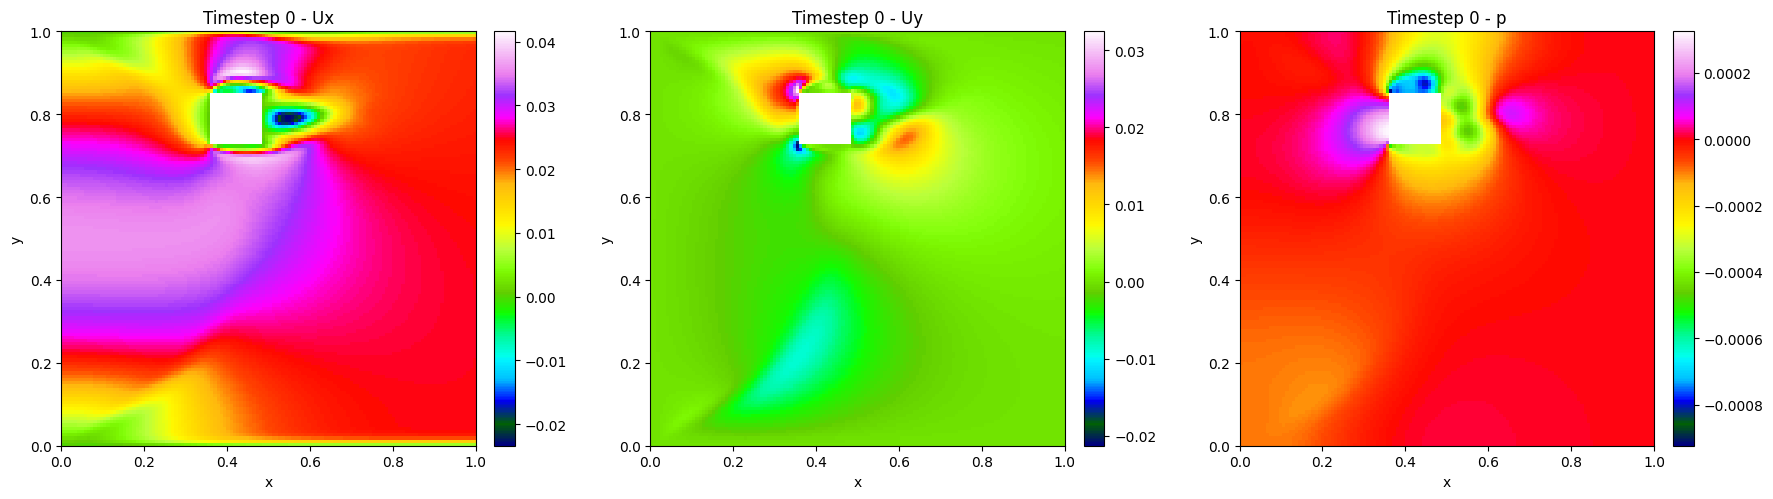

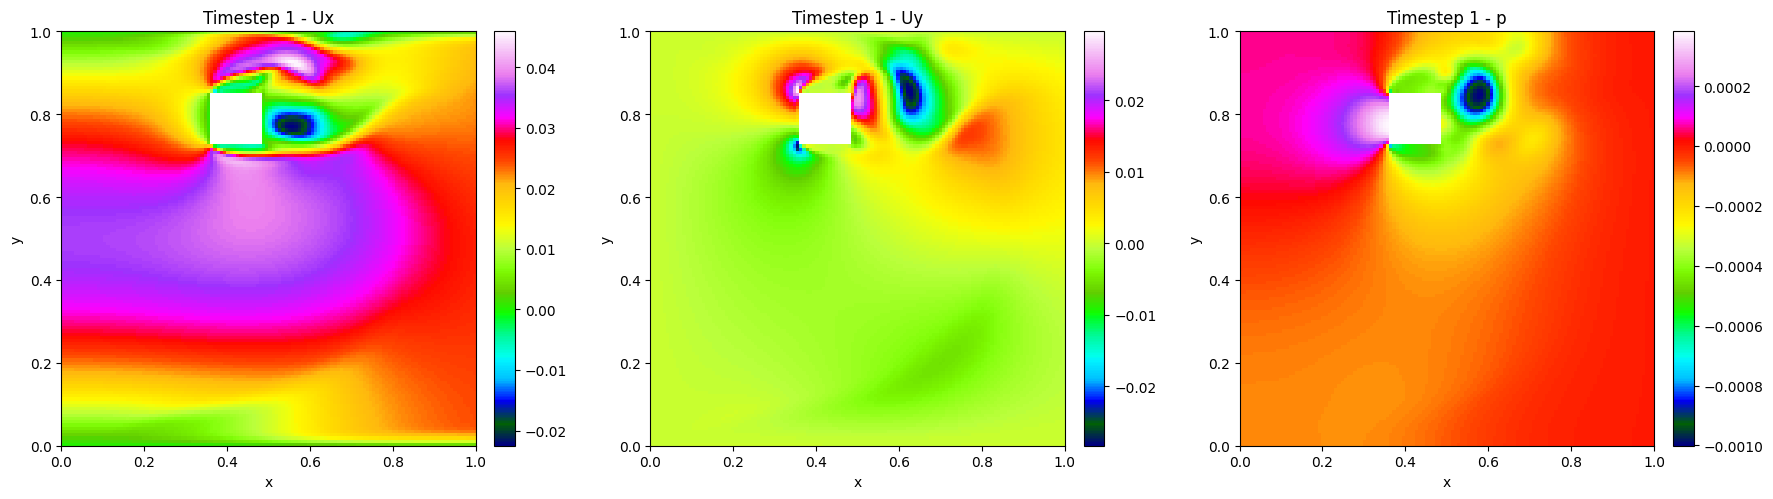

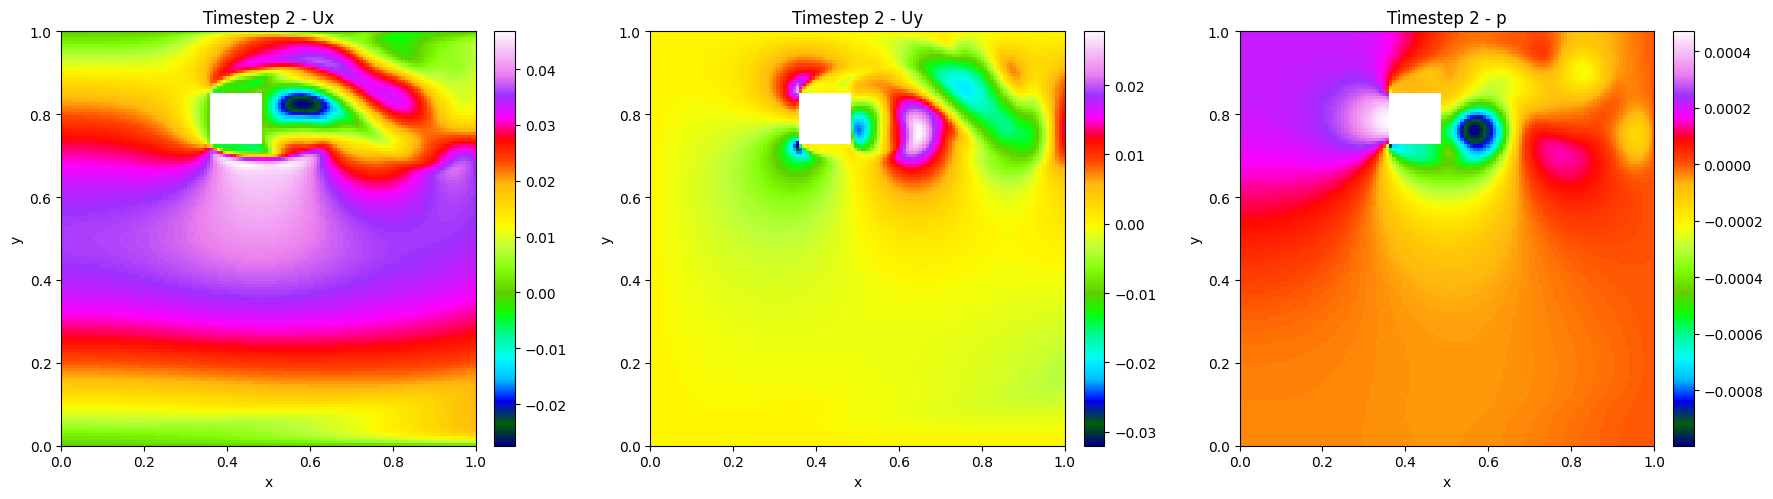

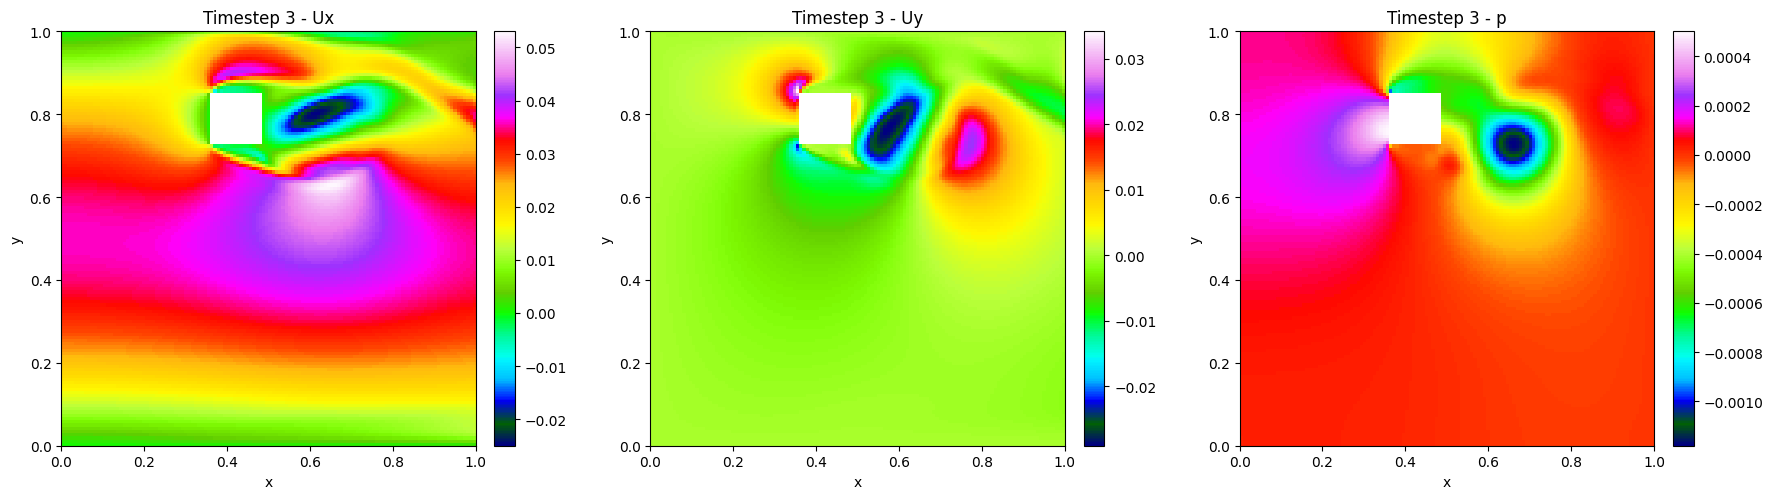

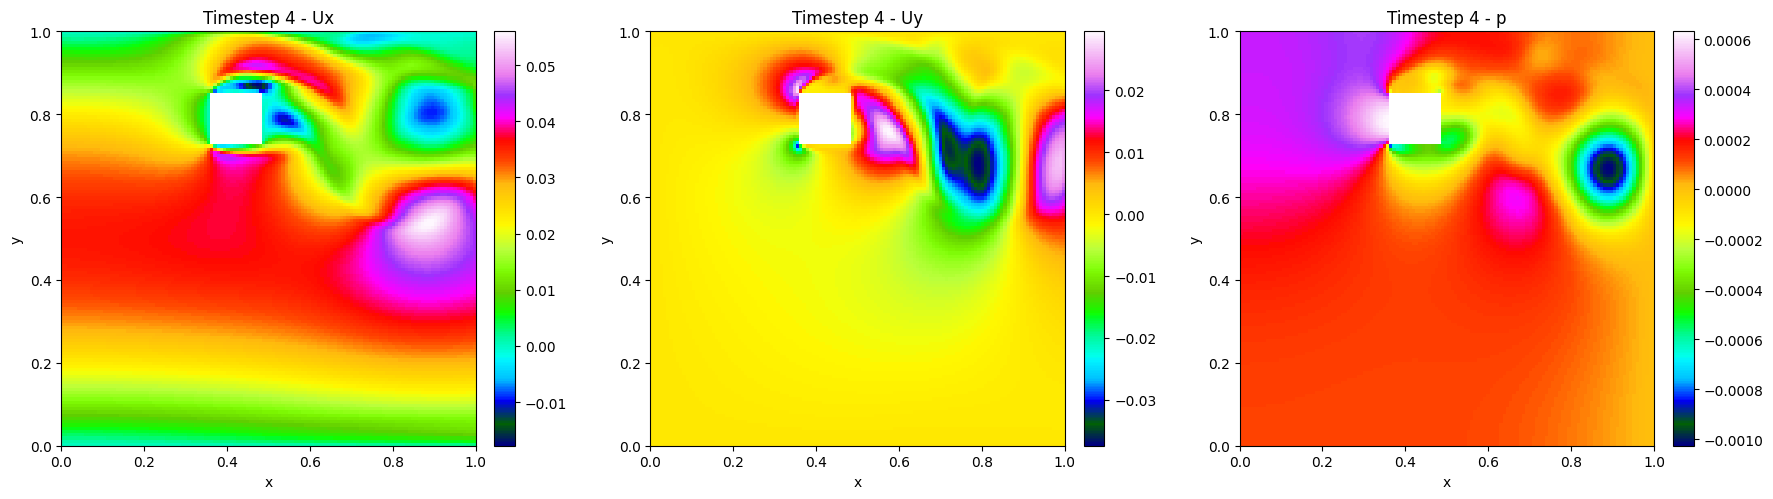

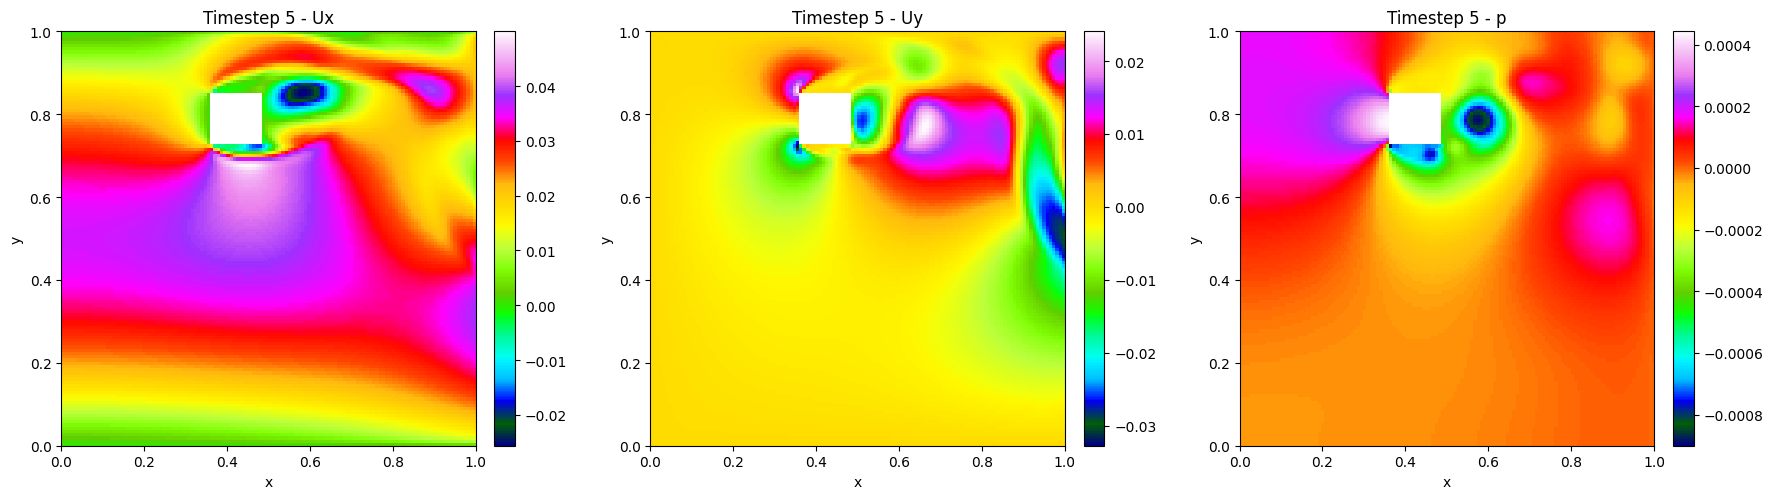

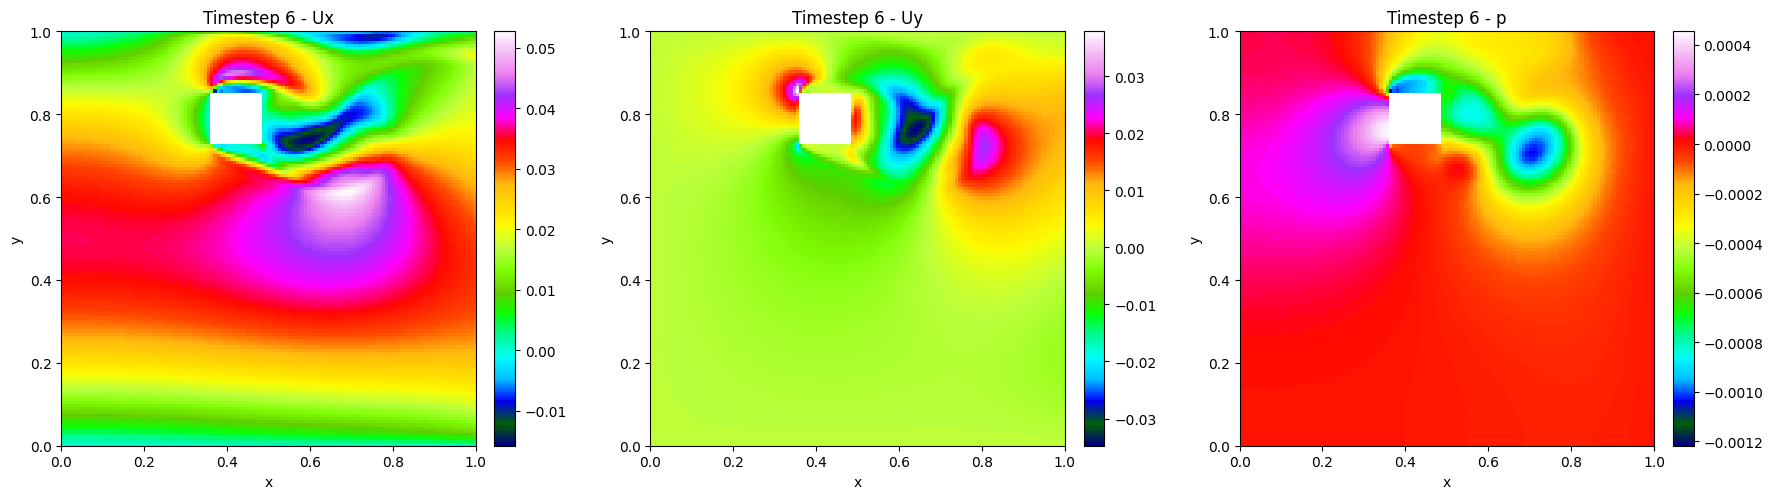

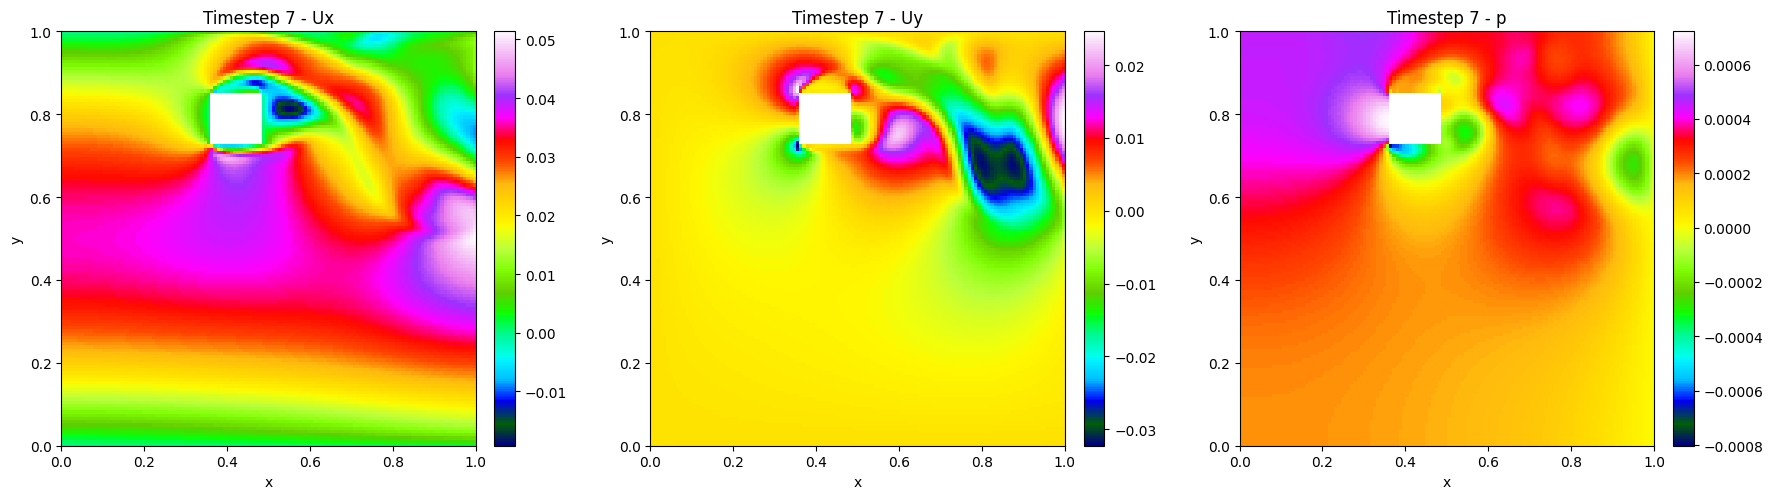

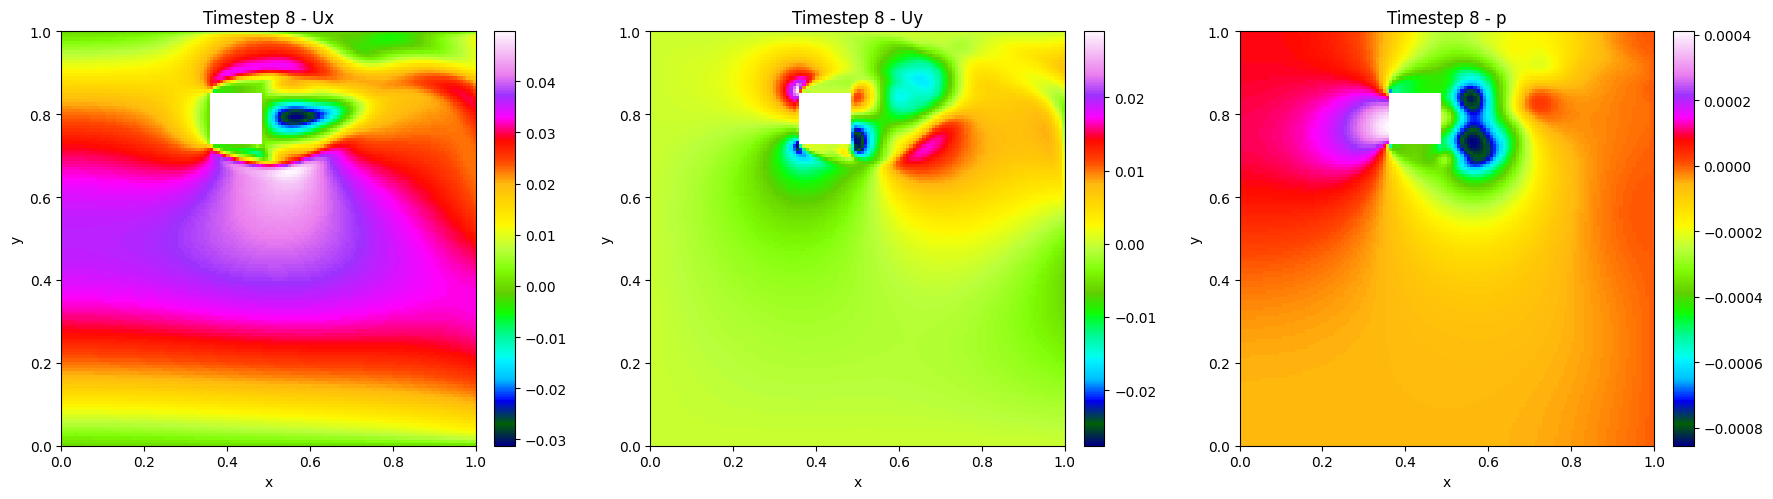

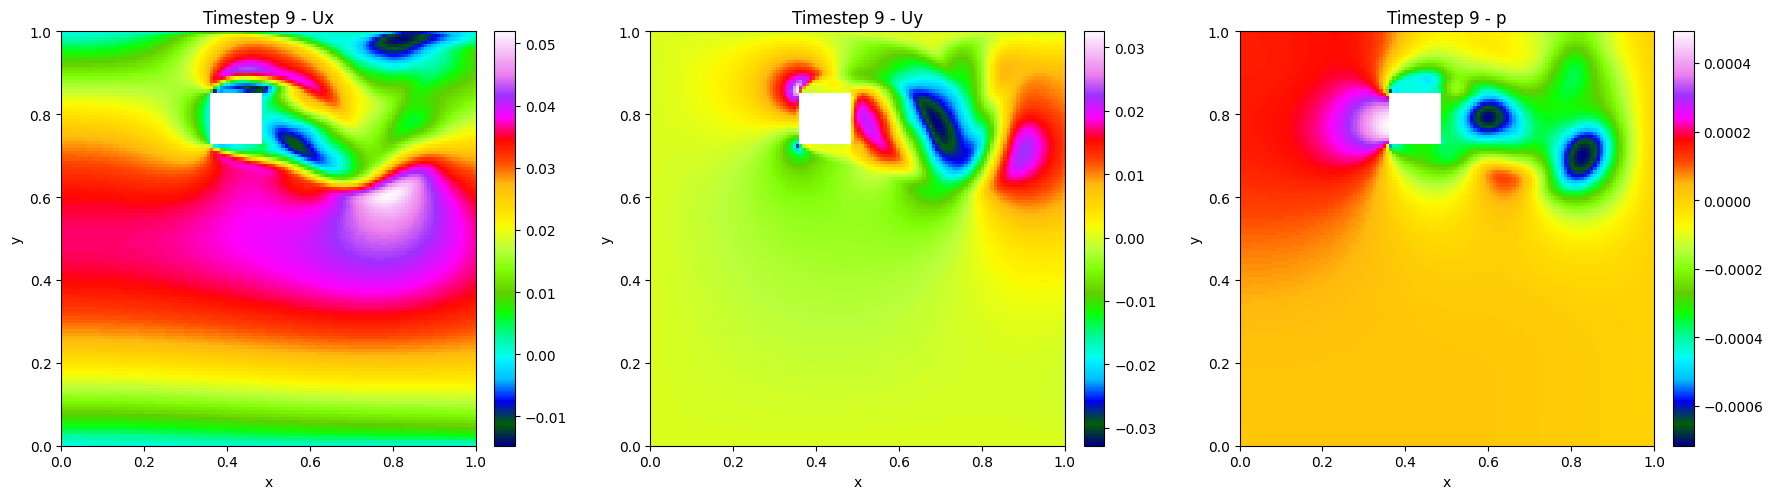

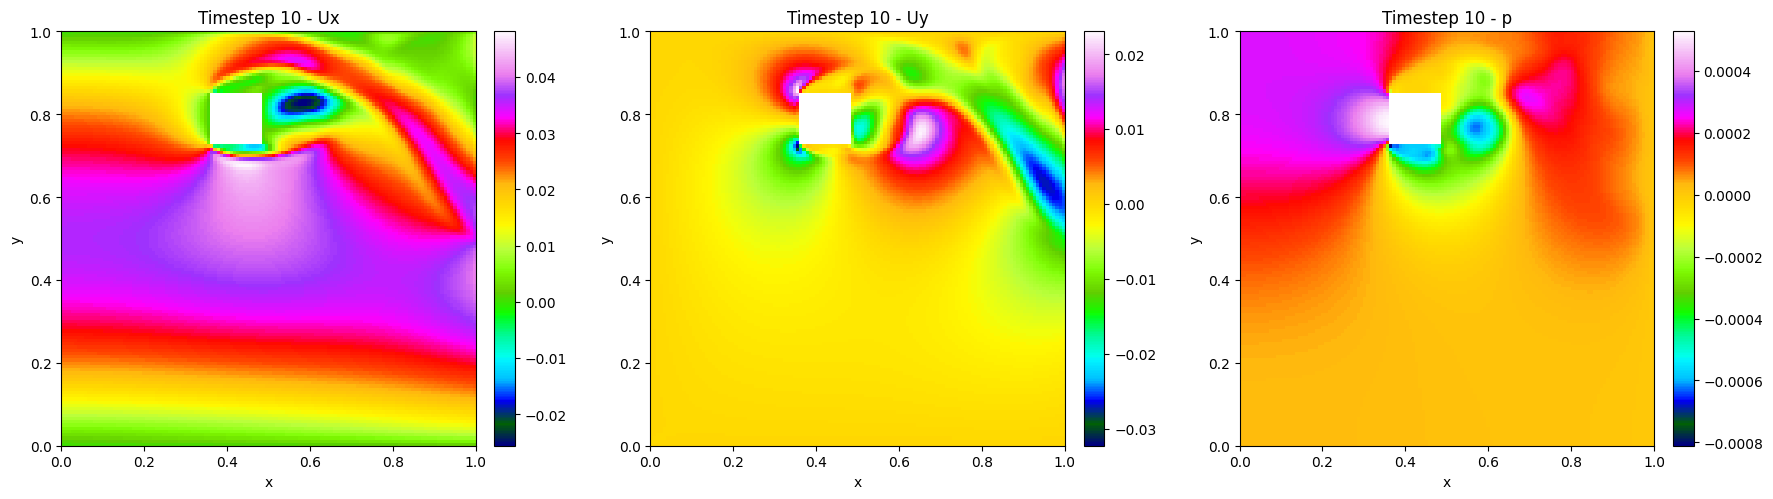

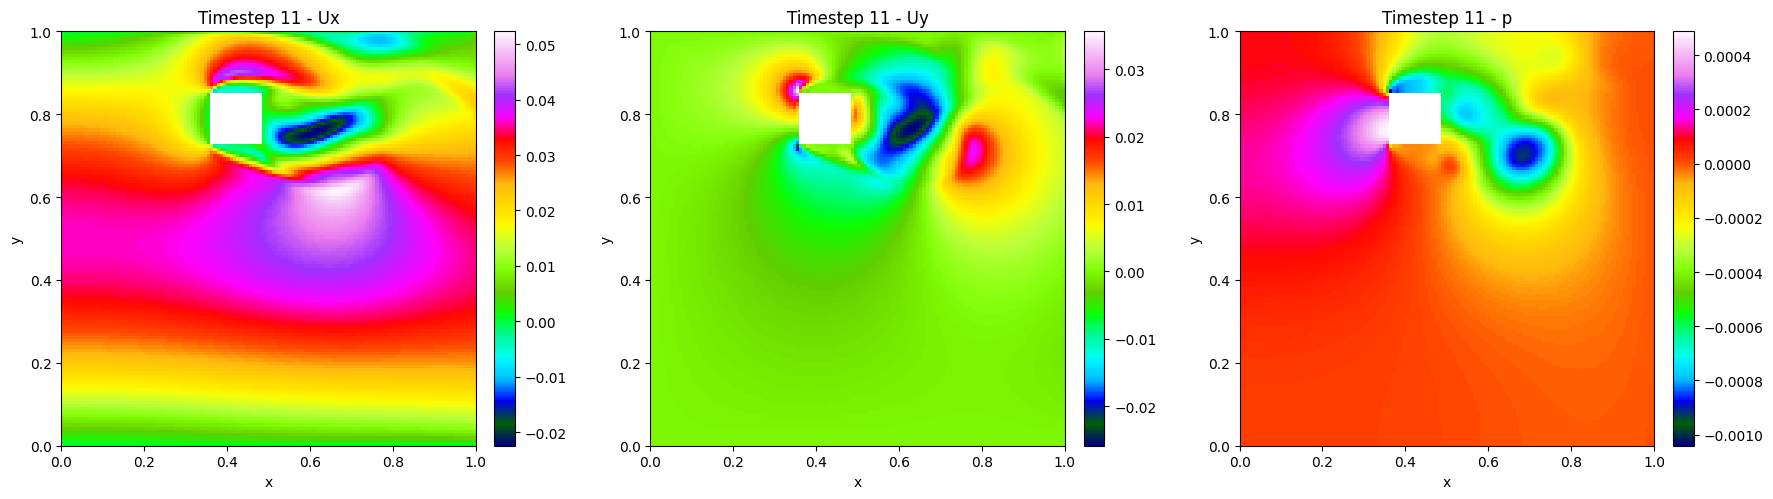

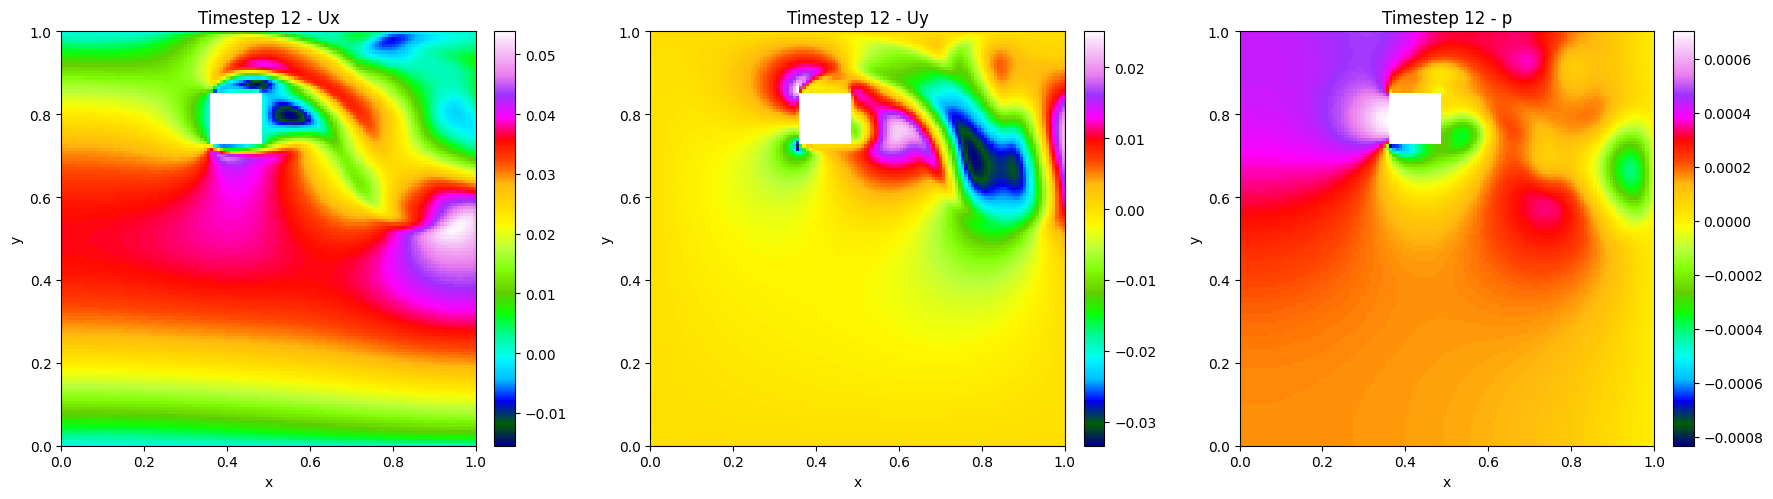

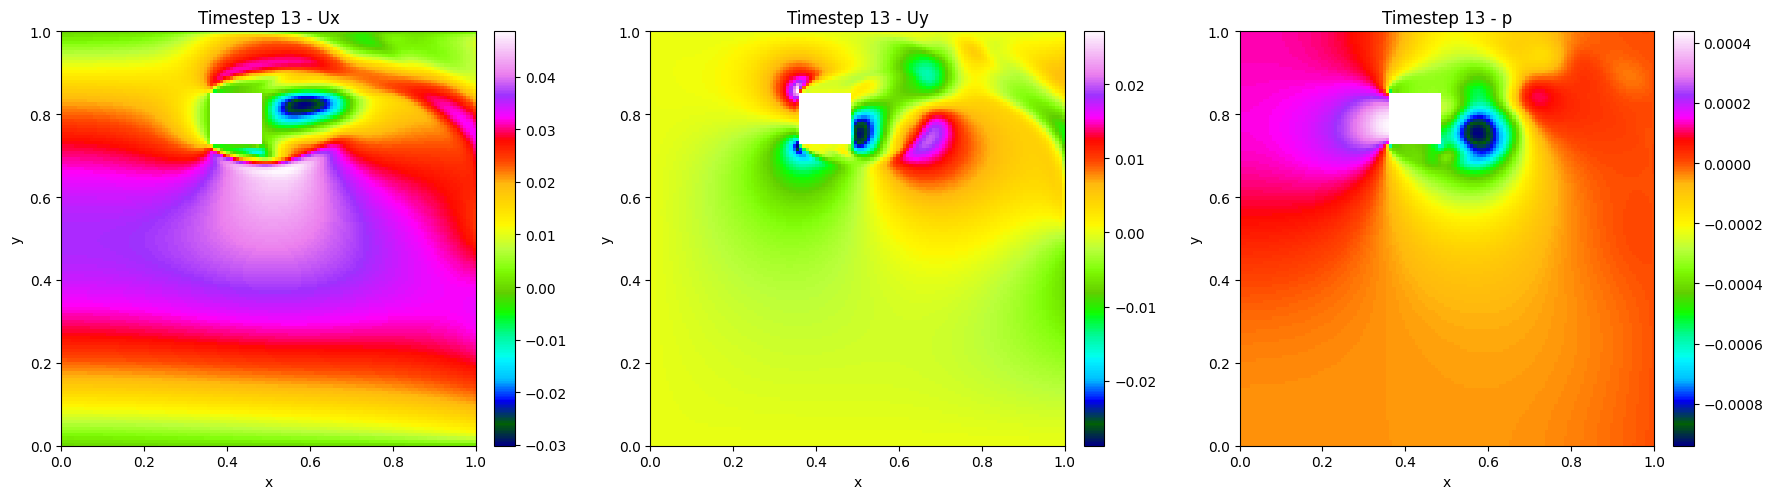

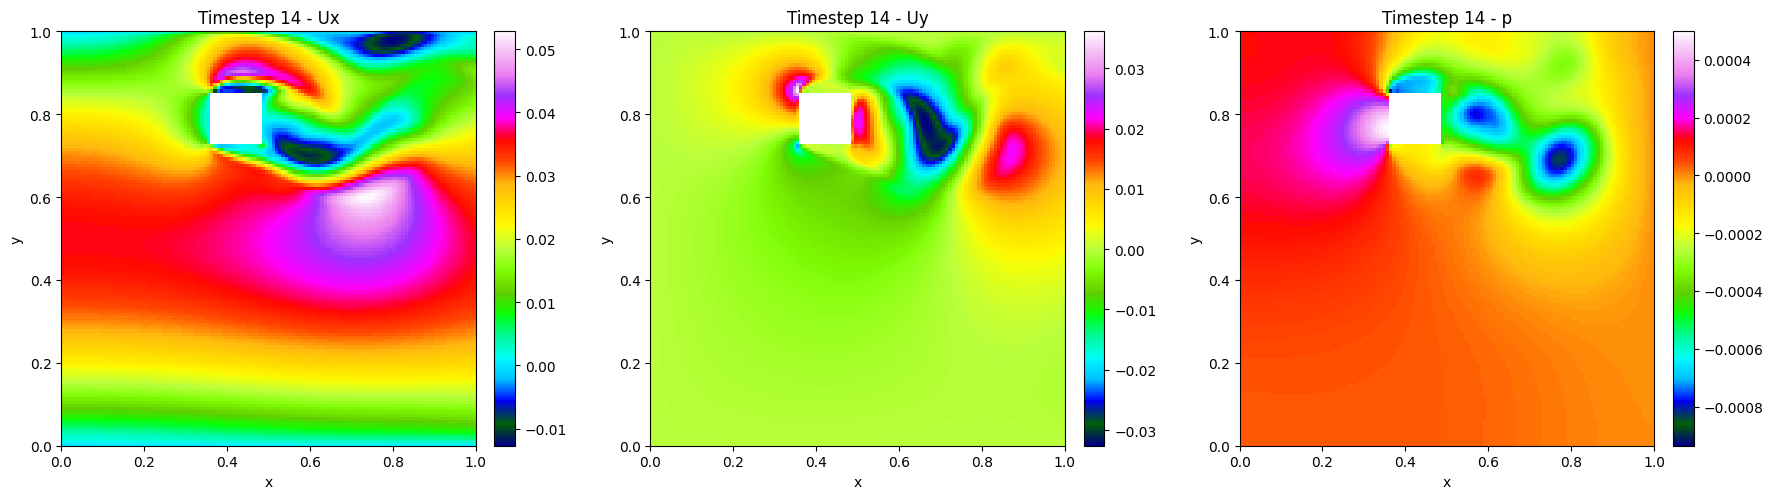

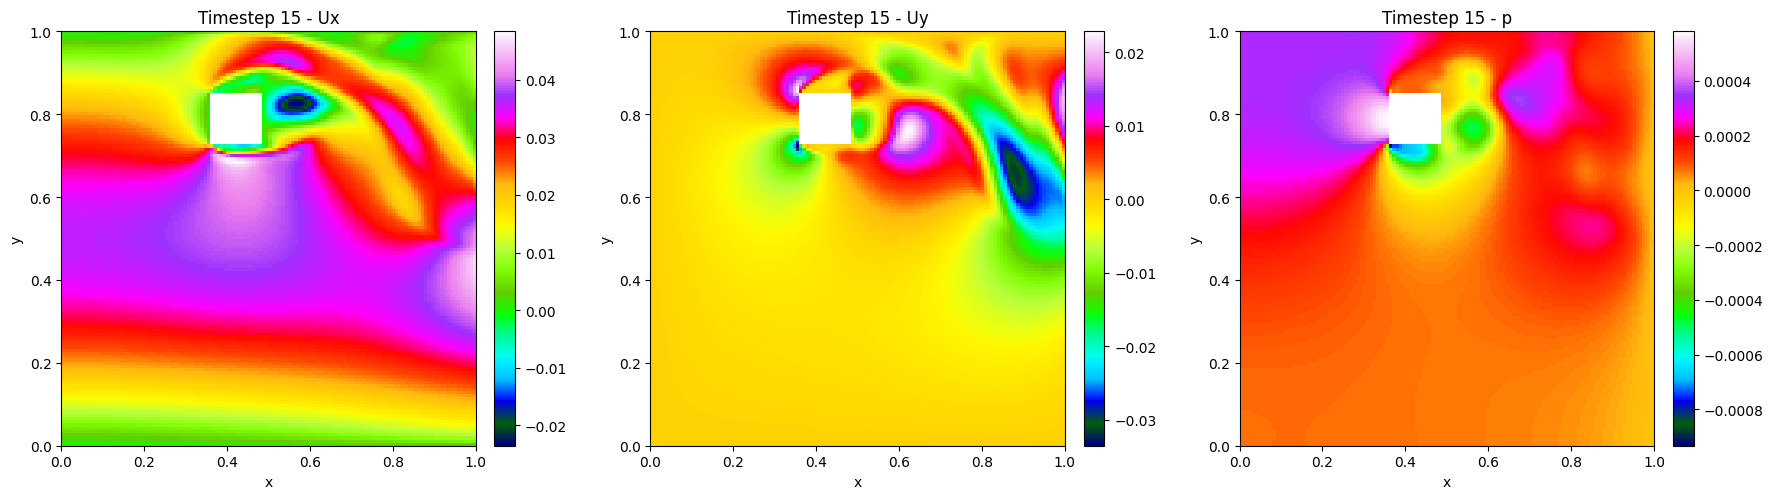

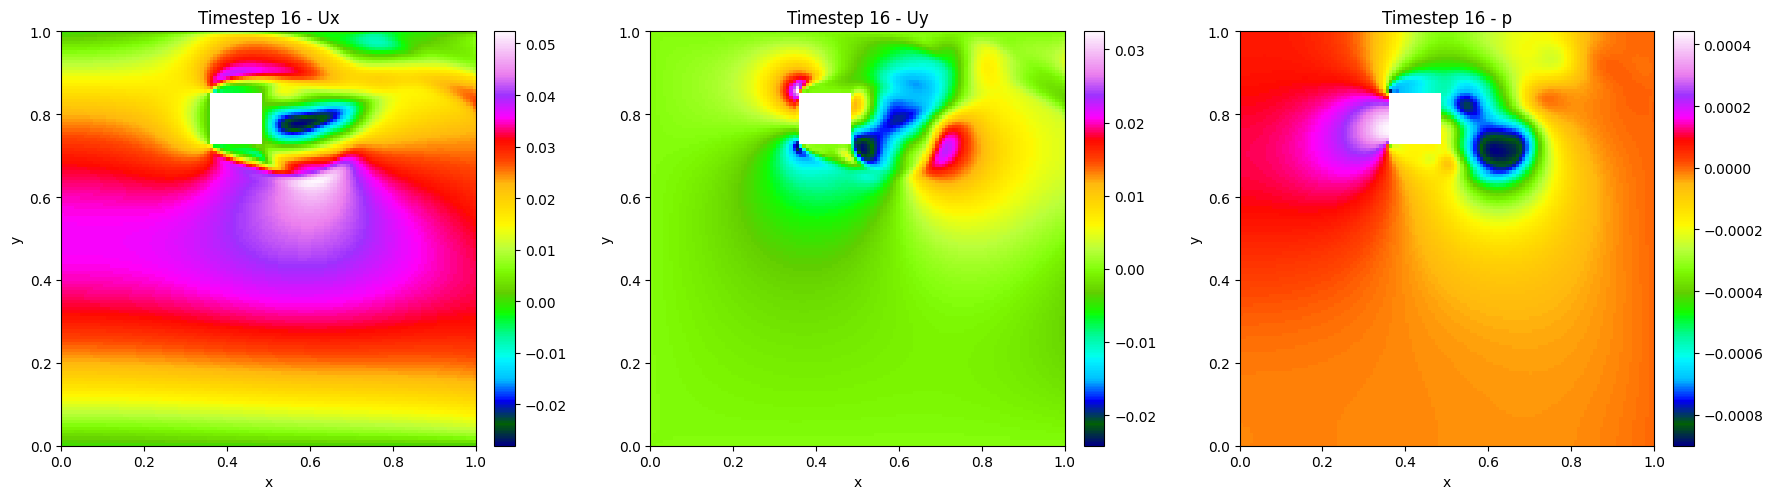

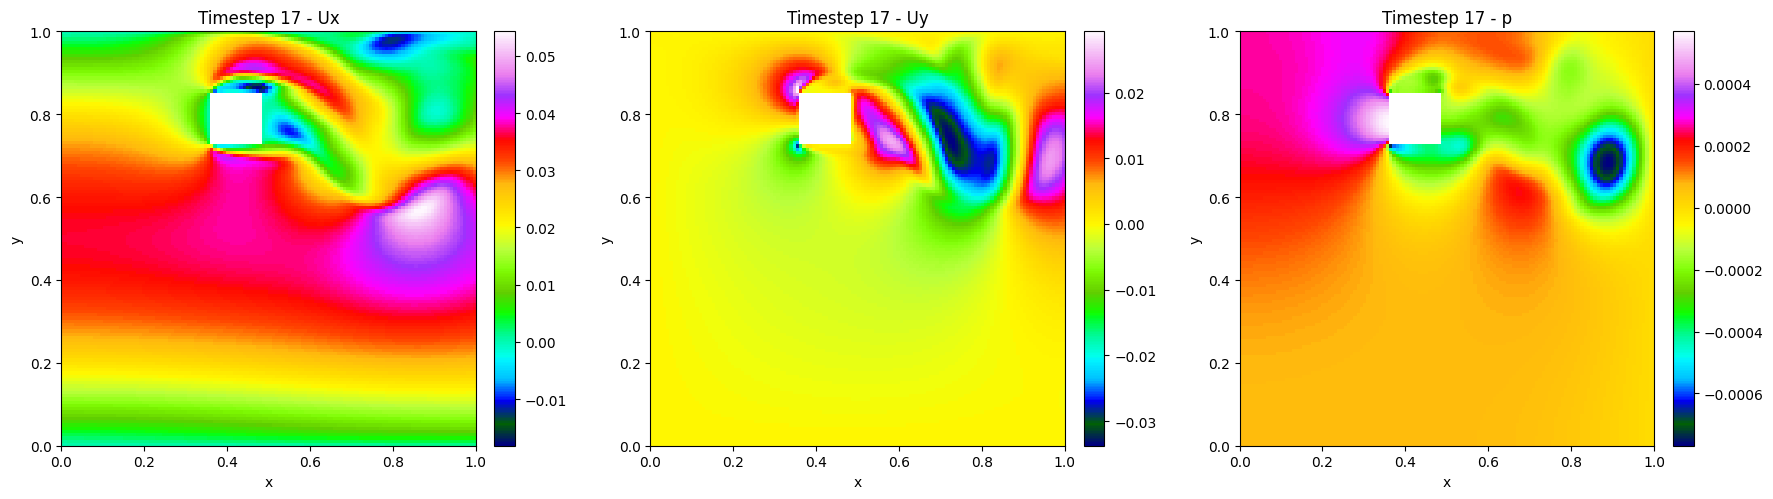

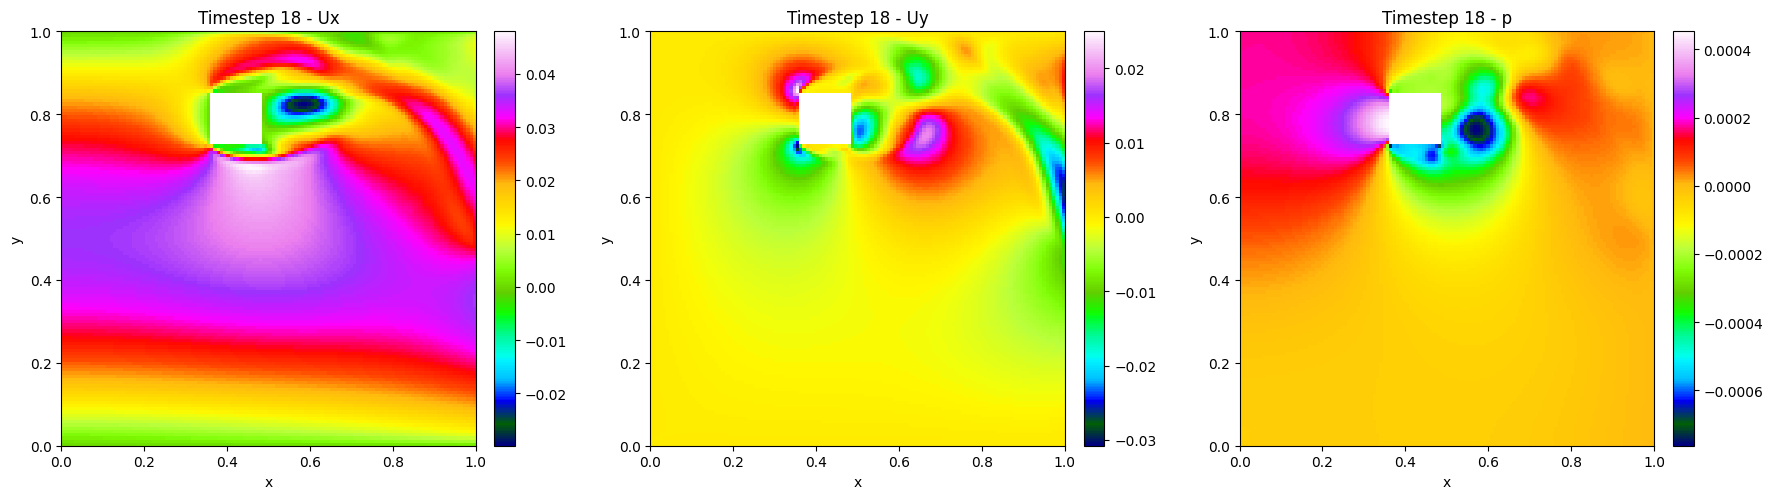

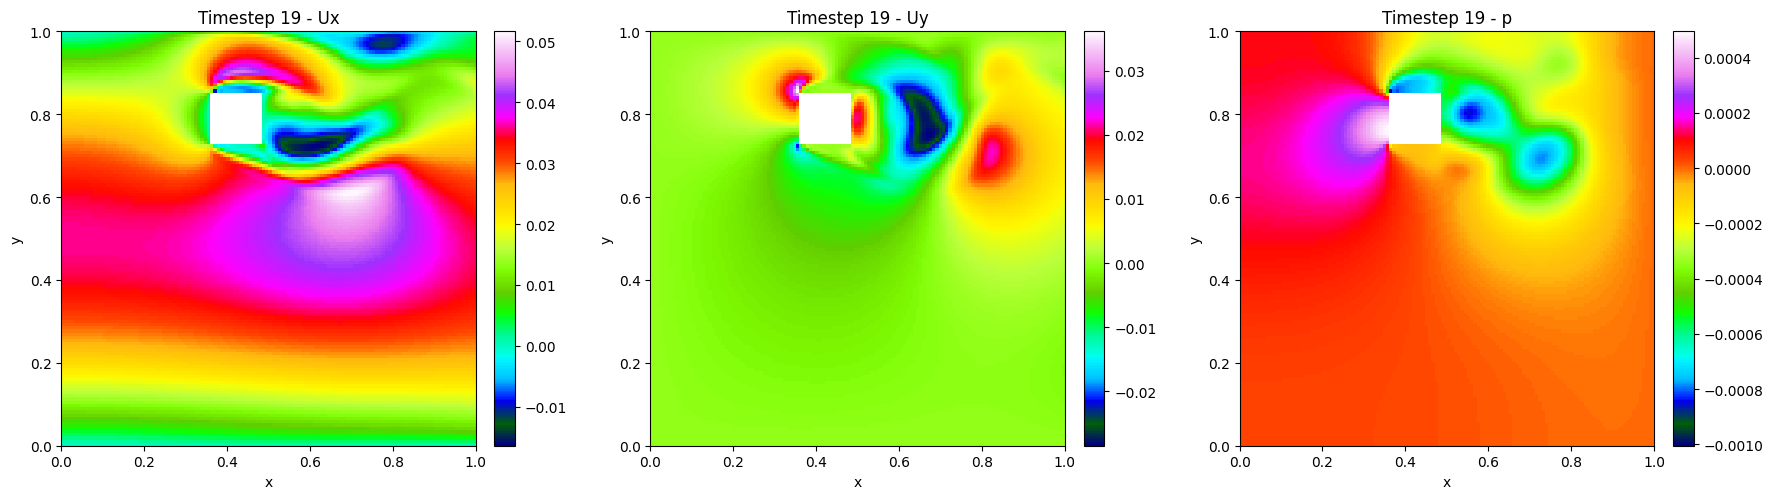

In [5]:
def visualize_dataset(data, trajectory_index=0):
    """
    Visualize all timesteps for the given trajectory while excluding hole cells.
    
    Data is assumed to have shape:
       (num_trajectories, timesteps, n_rows, n_cols, final_channels)
    where final_channels: 0=Ux, 1=Uy, 2=p, 3=hole indicator.
    
    This function displays Ux, Uy, and p for each timestep.
    """
    # Extract the trajectory to visualize
    traj_data = data[trajectory_index]  # shape: (timesteps, n_rows, n_cols, final_channels)
    timesteps, n_rows, n_cols, final_channels = traj_data.shape
    channel_names = ['Ux', 'Uy', 'p']
    
    for t in range(timesteps):
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        for ch in range(3):
            field = traj_data[t, :, :, ch]
            mask = traj_data[t, :, :, 4]  # Hole indicator
            masked_field = np.ma.masked_where(mask == 1, field)  # Mask out hole cells
            
            ax = axs[ch]
            cmap = "gist_ncar" if ch in [0, 1] else "gist_ncar"
            im = ax.imshow(masked_field, cmap=cmap, origin='lower', extent=[0, 1, 0, 1])
            ax.set_title(f"Timestep {t} - {channel_names[ch]}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

def main():
    # Load the reshaped dataset
    dataset = np.load("/data/user_data/namancho/FPO_cylinder_hole_location/final_reshaped_data.npy")
    print("Dataset shape:", dataset.shape)
    
    # Visualize the first trajectory (or change trajectory_index as needed)
    visualize_dataset(dataset, trajectory_index=50)

if __name__ == "__main__":
    main()

In [ ]:
import os
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import pandas as pd
# ========== HELPER FUNCTIONS (same as before) ==========
def parse_c_contents(c_contents):
    """
    Parses the OpenFOAM cell centers from a given 'c_contents' string.
    Expects the string to contain an 'internalField' entry.
    """
    lines = c_contents.split("\n")
    start_idx = None
    num_centres = None
    for i, line in enumerate(lines):
        if "internalField" in line:
            num_centres = int(lines[i+1].strip())
            start_idx = i + 3
            break
    if start_idx is None or num_centres is None:
        raise ValueError("Could not find 'internalField' or the number of cell centres in the content")
    coordinates = []
    for line in lines[start_idx:start_idx + num_centres]:
        if "(" in line and ")" in line:
            x, y, _ = map(float, line.strip("()\n").split())
            coordinates.append([x, y])
    return np.array(coordinates)
import numpy as np
import os
from scipy.ndimage import distance_transform_edt
def reshape_trajectory_data(sim_data, cell_centers, grid_shape):
    """
    Reshape simulation data (timesteps, num_cells, 4) to a fixed grid of shape
      (timesteps, n_rows, n_cols, 6).
    Input sim_data channels:
      0: Uₓ
      1: U_y
      2: p (pressure)
      3: Reynolds number
    Output grid channels:
      0: Uₓ
      1: U_y
      2: p (pressure)
      3: Reynolds number
      4: Binary mask (1 if fluid domain; 0 if hole)
      5: SDF (signed distance: positive in fluid, negative in hole)
    """
    n_rows, n_cols = grid_shape
    T = sim_data.shape[0]
    # Define Re normalization bounds
    Re_min = 100
    Re_max = 10000
    # Extract and normalize Re ONCE for the entire trajectory
    Re_raw = sim_data[0, 0, 3]
    Re_norm = np.clip((Re_raw - Re_min) / (Re_max - Re_min), 0.0, 1.0)
    # Determine domain boundaries from the cell centers.
    x_min, x_max = np.min(cell_centers[:, 0]), np.max(cell_centers[:, 0])
    y_min, y_max = np.min(cell_centers[:, 1]), np.max(cell_centers[:, 1])
    # Allocate output array with 6 channels.
    reshaped = np.zeros((T, n_rows, n_cols, 6), dtype=np.float32)
    # 2) Create the binary hole mask.
    # Initialize with zeros (assume hole) then mark fluid cells with 1.
    mask = np.ones((n_rows, n_cols), dtype=np.float32)
    mapping = []
    for (x, y) in cell_centers:
        col = int(round((x - x_min) / (x_max - x_min) * (n_cols - 1)))
        row = int(round((y - y_min) / (y_max - y_min) * (n_rows - 1)))
        mapping.append((row, col))
        mask[row, col] = 0  # Mark fluid domain
    # 3) Compute the signed distance function (SDF) on the grid.
    # Use distance_transform_edt on the mask and its inverse.
    outside_dist = distance_transform_edt(mask == 0)
    inside_dist = distance_transform_edt(mask == 1)
    sdf_field = outside_dist - inside_dist
    # # Normalize SDF to range [-1, 1]
    # max_abs = np.max(np.abs(sdf_field))
    # sdf_field = sdf_field / max_abs
    # Normalize SDF to range [-1, 1]
    max_abs_sdf = np.max(np.abs(sdf_field))
    if max_abs_sdf > 0:
        sdf = sdf_field / max_abs_sdf
    # Assign Re to all time steps and all cells
    reshaped[:, :, :, 3] = Re_norm
    # 4) Fill the simulation data into channels 0-4.
    # For each time step, place the 5 channels from sim_data into the grid.
    for t in range(T):
        for i, (row, col) in enumerate(mapping):
            reshaped[t, row, col, 0:3] = sim_data[t, i, 0:3]
    # 5) Set the binary mask channel (channel 5) and SDF channel (channel 6) for every time step.
    for t in range(T):
        reshaped[t, :, :, 4] = mask
        reshaped[t, :, :, 5] = sdf
    return reshaped
def combine_and_reshape_trajectories(dataset, sim_data_list, grid_shape, save_folder, file_name="combined.npy"):
    """
    Combines and reshapes trajectory data from multiple simulations.
    Parameters:
      dataset: np.ndarray of shape (num_trajectories, timesteps, num_cells, 4)
               (4 channels: [Uₓ, U_y, p, Reynolds number])
      sim_data_list: list of dicts, each with keys "folder" and "c_contents"
      grid_shape: tuple (n_rows, n_cols) defining the target grid dimensions.
      save_folder: directory where the combined .npy file will be saved.
      file_name: name of the output .npy file (default "combined.npy").
    Returns:
      combined: np.ndarray of shape (num_trajectories, timesteps, n_rows, n_cols, 6)
      with channels:
          0: Uₓ
          1: U_y
          2: p
          3: Reynolds number
          4: Binary mask (hole indicator)
          5: SDF (signed distance function)
    """
    from tqdm import tqdm
    import gc
    num_trajectories = dataset.shape[0]
    if num_trajectories != len(sim_data_list):
        raise ValueError(f"Number of simulations in .npy ({num_trajectories}) does not match the number of JSON entries ({len(sim_data_list)}).")
    combined_list = []
    for i in tqdm(range(num_trajectories), desc="Reshaping Trajectories"):
        sim_data = dataset[i]  # (timesteps, num_cells, 5)
        entry = sim_data_list[i]
        folder_name = entry["folder"]
        c_contents = entry["c_contents"]
        # Parse the cell centers from the c_contents.
        cell_centers = parse_c_contents(c_contents)
        reshaped_data = reshape_trajectory_data(sim_data, cell_centers, grid_shape)
        combined_list.append(reshaped_data)
        gc.collect()
    combined = np.array(combined_list, dtype=np.float32)
    os.makedirs(save_folder, exist_ok=True)
    save_path = os.path.join(save_folder, file_name)
    np.save(save_path, combined)
    print(f"Saved combined trajectory data at: {save_path}")
    return combined
def save_grid_to_file(grid, filename):
    """
    Saves the grid values to a text file in a readable format.
    Each row corresponds to a row in the grid, making it easy to verify values.
    """
    df = pd.DataFrame(grid)
    df.to_csv(filename, sep='\t', header=False, index=False)
    print(f"Saved grid values to {filename}")
# For testing the SDF and mask extraction:
def test_sdf_and_mask_extraction():
    # Load data from the testing file (assumes output has shape (..., 128, 128, 9))
    data = np.load("testingsdf.npy")
    # According to our new ordering:
    # SDF is in channel 6 and geometry mask is in channel 5.
    sdf_sample = data[0, 0, :, :, 5]         # first trajectory, first timestep, SDF values
    geometry_mask_sample = data[0, 0, :, :, 4] # first trajectory, first timestep, mask values
    # Save extracted grids to files.
    save_grid_to_file(sdf_sample, "sdf_values_from_testingsdf.txt")
    save_grid_to_file(geometry_mask_sample, "geometry_mask_from_testingsdf.txt")
def plot_with_hole_white(
    trajectory,
    channel_names=["Ux", "Uy", "P", "Re", "mask", "sdf"],
    tol=1e-8
):
    """
    Plot each timestep of a trajectory such that values whose absolute value
    is below a given tolerance are displayed as white (masked).
    """
    cmap = matplotlib.cm.get_cmap('gist_ncar').copy()
    cmap.set_bad(color='white')
    n_timesteps = trajectory.shape[0]
    for t in range(n_timesteps):
        data = trajectory[t]
        n_channels = data.shape[-1]
        fig, axes = plt.subplots(1, n_channels, figsize=(4*n_channels, 4))
        for ch in range(n_channels):
            masked_channel = np.ma.masked_where(np.abs(data[:, :, ch]) < tol, data[:, :, ch])
            valid_vals = data[:, :, ch][np.abs(data[:, :, ch]) >= tol]
            if valid_vals.size > 0:
                vmin, vmax = valid_vals.min(), valid_vals.max()
            else:
                vmin, vmax = 0, 1
            im = axes[ch].imshow(masked_channel, cmap=cmap, vmin=vmin, vmax=vmax)
            axes[ch].set_title(f"{channel_names[ch]} | Timestep {t}")
            axes[ch].axis("off")
            fig.colorbar(im, ax=axes[ch], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        plt.close(fig)
def main():
    root_dir = "/data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location"
    grid_shape = (128, 128)
    temp_batch_paths = []

    batch_dirs = sorted(
        [os.path.join(root_dir, d) for d in os.listdir(root_dir)
         if os.path.isdir(os.path.join(root_dir, d))],
        key=lambda x: int(os.path.basename(x).replace("batch_", ""))
    )

    temp_dir = os.path.join(root_dir, "temp_batches")
    os.makedirs(temp_dir, exist_ok=True)

    batch_counter = 0

    for batch_dir in tqdm(batch_dirs, desc="Processing Batches"):
        for i in [1, 2]:
            npy_path = os.path.join(batch_dir, f"2results_batch_{i}.npy")
            json_path = os.path.join(batch_dir, f"2sim_data_batch_{i}.json")

            if not os.path.exists(npy_path) or not os.path.exists(json_path):
                print(f"❌ Missing files in {batch_dir} for batch_{i}, skipping...")
                continue

            print(f"\n➡️ Processing {npy_path} and {json_path}")
            data = np.load(npy_path)
            with open(json_path, "r") as f:
                raw_entries = json.load(f)

            if data.shape[0] != len(raw_entries):
                raise ValueError(f"Mismatch in {batch_dir}: {data.shape[0]} vs {len(raw_entries)}")

            reshaped = combine_and_reshape_trajectories(
                data, raw_entries, grid_shape, save_folder="/tmp", file_name="scratch.npy"
            )

            # Save temporary batch to disk
            temp_path = os.path.join(temp_dir, f"reshaped_batch_{batch_counter}.npy")
            np.save(temp_path, reshaped)
            temp_batch_paths.append(temp_path)
            batch_counter += 1

            del data, raw_entries, reshaped
            gc.collect()

    print("\n📦 Starting final concatenation from temp files...")
    reshaped_batches = [np.load(p) for p in temp_batch_paths]
    final_data = np.concatenate(reshaped_batches, axis=0)

    final_save_path = os.path.join(root_dir, "final_reshaped_data_norm.npy")
    np.save(final_save_path, final_data)

    print(f"\n✅ Final combined dataset saved at: {final_save_path}")
    print(f"🧩 Final shape: {final_data.shape}")

if __name__ == "__main__":
    main()

Processing Batches:   0%|          | 0/40 [00:00<?, ?it/s]


➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_0/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_0/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_0/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_0/2sim_data_batch_2.json


Processing Batches:   2%|▎         | 1/40 [01:16<49:44, 76.53s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_1/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_1/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.74it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_1/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_1/2sim_data_batch_2.json


Processing Batches:   5%|▌         | 2/40 [02:33<48:32, 76.65s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_2/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_2/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_2/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_2/2sim_data_batch_2.json


Processing Batches:   8%|▊         | 3/40 [03:50<47:18, 76.71s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_3/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_3/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_3/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_3/2sim_data_batch_2.json


Processing Batches:  10%|█         | 4/40 [05:06<46:00, 76.67s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_4/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_4/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_4/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_4/2sim_data_batch_2.json


Processing Batches:  12%|█▎        | 5/40 [06:23<44:44, 76.71s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_5/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_5/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_5/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_5/2sim_data_batch_2.json


Processing Batches:  15%|█▌        | 6/40 [07:40<43:28, 76.73s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_6/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_6/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_6/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_6/2sim_data_batch_2.json


Processing Batches:  18%|█▊        | 7/40 [08:56<42:10, 76.69s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_7/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_7/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:33<00:00,  3.77it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_7/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_7/2sim_data_batch_2.json


Processing Batches:  20%|██        | 8/40 [10:13<40:52, 76.65s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_8/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_8/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_8/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_8/2sim_data_batch_2.json


Processing Batches:  22%|██▎       | 9/40 [11:30<39:41, 76.82s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_9/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_9/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.76it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_9/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_9/2sim_data_batch_2.json


Processing Batches:  25%|██▌       | 10/40 [12:47<38:23, 76.79s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_10/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_10/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_10/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_10/2sim_data_batch_2.json


Processing Batches:  28%|██▊       | 11/40 [14:03<37:03, 76.68s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_11/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_11/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_11/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_11/2sim_data_batch_2.json


Processing Batches:  30%|███       | 12/40 [15:20<35:50, 76.79s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_12/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_12/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:35<00:00,  3.65it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_12/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_12/2sim_data_batch_2.json


Processing Batches:  32%|███▎      | 13/40 [16:39<34:50, 77.43s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_13/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_13/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.71it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_13/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_13/2sim_data_batch_2.json


Processing Batches:  35%|███▌      | 14/40 [17:57<33:32, 77.42s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_14/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_14/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.73it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_14/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_14/2sim_data_batch_2.json


Processing Batches:  38%|███▊      | 15/40 [19:14<32:14, 77.37s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_15/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_15/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.76it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_15/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_15/2sim_data_batch_2.json


Processing Batches:  40%|████      | 16/40 [20:31<30:52, 77.18s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_16/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_16/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_16/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_16/2sim_data_batch_2.json


Processing Batches:  42%|████▎     | 17/40 [21:47<29:32, 77.08s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_17/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_17/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_17/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_17/2sim_data_batch_2.json


Processing Batches:  45%|████▌     | 18/40 [23:04<28:13, 76.98s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_18/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_18/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_18/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_18/2sim_data_batch_2.json


Processing Batches:  48%|████▊     | 19/40 [24:21<26:55, 76.91s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_19/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_19/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_19/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_19/2sim_data_batch_2.json


Processing Batches:  50%|█████     | 20/40 [25:38<25:42, 77.11s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_20/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_20/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_20/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_20/2sim_data_batch_2.json


Processing Batches:  52%|█████▎    | 21/40 [26:55<24:22, 77.00s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_21/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_21/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.74it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_21/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_21/2sim_data_batch_2.json


Processing Batches:  55%|█████▌    | 22/40 [28:13<23:08, 77.14s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_22/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_22/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.75it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_22/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_22/2sim_data_batch_2.json


Processing Batches:  57%|█████▊    | 23/40 [29:30<21:50, 77.08s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_23/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_23/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.73it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_23/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_23/2sim_data_batch_2.json


Processing Batches:  60%|██████    | 24/40 [30:47<20:35, 77.21s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_24/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_24/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_24/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_24/2sim_data_batch_2.json


Processing Batches:  62%|██████▎   | 25/40 [32:04<19:18, 77.25s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_25/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_25/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.72it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_25/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_25/2sim_data_batch_2.json


Processing Batches:  65%|██████▌   | 26/40 [33:21<18:00, 77.18s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_26/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_26/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.72it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_26/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_26/2sim_data_batch_2.json


Processing Batches:  68%|██████▊   | 27/40 [34:39<16:43, 77.19s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_27/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_27/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.72it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_27/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_27/2sim_data_batch_2.json


Processing Batches:  70%|███████   | 28/40 [35:58<15:33, 77.79s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_28/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_28/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_28/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_28/2sim_data_batch_2.json


Processing Batches:  72%|███████▎  | 29/40 [37:16<14:16, 77.89s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_29/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_29/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_29/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_29/2sim_data_batch_2.json


Processing Batches:  75%|███████▌  | 30/40 [38:34<12:59, 77.91s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_30/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_30/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.69it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_30/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_30/2sim_data_batch_2.json


Processing Batches:  78%|███████▊  | 31/40 [39:52<11:42, 78.01s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_31/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_31/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_31/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_31/2sim_data_batch_2.json


Processing Batches:  80%|████████  | 32/40 [41:11<10:25, 78.21s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_32/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_32/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.71it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_32/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_32/2sim_data_batch_2.json


Processing Batches:  82%|████████▎ | 33/40 [42:29<09:07, 78.18s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_33/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_33/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_33/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_33/2sim_data_batch_2.json


Processing Batches:  85%|████████▌ | 34/40 [43:47<07:48, 78.14s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_34/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_34/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_34/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_34/2sim_data_batch_2.json


Processing Batches:  88%|████████▊ | 35/40 [45:05<06:30, 78.13s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_35/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_35/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_35/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_35/2sim_data_batch_2.json


Processing Batches:  90%|█████████ | 36/40 [46:23<05:12, 78.06s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_36/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_36/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_36/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_36/2sim_data_batch_2.json


Processing Batches:  92%|█████████▎| 37/40 [47:41<03:54, 78.06s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_37/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_37/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.71it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_37/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_37/2sim_data_batch_2.json


Processing Batches:  95%|█████████▌| 38/40 [48:59<02:36, 78.03s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_38/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_38/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.71it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_38/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_38/2sim_data_batch_2.json


Processing Batches:  98%|█████████▊| 39/40 [50:17<01:17, 77.97s/it]

Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_39/2results_batch_1.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_39/2sim_data_batch_1.json


Reshaping Trajectories: 100%|██████████| 128/128 [00:34<00:00,  3.71it/s]


Saved combined trajectory data at: /tmp/scratch.npy

➡️ Processing /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_39/2results_batch_2.npy and /data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/batch_39/2sim_data_batch_2.json


Processing Batches: 100%|██████████| 40/40 [51:35<00:00, 77.39s/it]

Saved combined trajectory data at: /tmp/scratch.npy


: 

In [2]:
pip install pandas

  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import json
import gc
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

def parse_c_contents(c_contents: str) -> np.ndarray:
    """Extract (x,y) centres from an OpenFOAM c file’s internalField block."""
    lines = c_contents.splitlines()
    for i, L in enumerate(lines):
        if "internalField" in L:
            N = int(lines[i+1].strip())
            start = i + 3
            break
    else:
        raise ValueError("Could not find internalField")
    coords = []
    for line in lines[start:start+N]:
        x, y, _ = map(float, line.strip("(); ").split())
        coords.append((x, y))
    return np.array(coords, dtype=float)

def reshape_trajectory_data(
    sim_data: np.ndarray,
    cell_centers: np.ndarray,
    grid_shape: tuple[int,int],
    re_bounds=(100, 1e4)
) -> np.ndarray:
    """
    sim_data: (T, M, 4) channels [Ux, Uy, p, Re_raw]
    Returns:  (T, H, W, 6) channels [Ux, Uy, p, Re_norm, mask, sdf]
    """
    T, M, _ = sim_data.shape
    H, W = grid_shape

    # — Re‐normalization (your original formula)
    Re_raw = sim_data[0, 0, 3]
    Re_min, Re_max = re_bounds
    Re_norm = float(np.clip((Re_raw - Re_min) / (Re_max - Re_min), 0, 1))

    # — build mask & mapping
    xs, ys = cell_centers[:,0], cell_centers[:,1]
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()

    mask = np.ones((H, W), dtype=np.uint8)  # 1=fluid, 0=hole
    mapping = []
    for (x, y) in cell_centers:
        i = int(round((y - ymin) / (ymax - ymin) * (H - 1)))
        j = int(round((x - xmin) / (xmax - xmin) * (W - 1)))
        mask[i, j] = 0
        mapping.append((i, j))

    # — signed‐distance field (SDF), normalized to [-1,1]
    d_out = distance_transform_edt(mask == 0)
    d_in  = distance_transform_edt(mask == 1)
    sdf   = (d_out - d_in).astype(np.float32)
    mx = np.abs(sdf).max()
    if mx > 0:
        sdf /= mx

    # — allocate & fill
    out = np.zeros((T, H, W, 6), dtype=np.float32)
    out[..., 3] = Re_norm   # channel 3
    out[..., 4] = mask      # channel 4
    out[..., 5] = sdf       # channel 5

    for t in range(T):
        step = sim_data[t]  # (M,4)
        for idx, (i, j) in enumerate(mapping):
            out[t, i, j, 0:3] = step[idx, 0:3]

    return out

def plot_trajectory(trajectory: np.ndarray, channel_names=None):
    """Histogram of each channel for one trajectory (shape T×H×W×6)."""
    if channel_names is None:
        channel_names = ["Ux","Uy","p","Re_norm","mask","sdf"]
    for c, name in enumerate(channel_names):
        data = trajectory[..., c].ravel()
        plt.figure(figsize=(6,4))
        plt.hist(data, bins=50, alpha=0.7)
        plt.title(f"{name} distribution (traj 0)")
        plt.xlabel(name); plt.ylabel("Count")
        plt.tight_layout(); plt.show()

def main(
    root_dir: str,
    grid_shape=(128,128),
    output_path="final_reshaped.npy"
):
    # 1) Gather all (npy, json) pairs
    sims = []
    for batch in sorted(os.listdir(root_dir)):
        bdir = os.path.join(root_dir, batch)
        if not os.path.isdir(bdir): continue
        for i in (1,2):
            npy_f  = os.path.join(bdir, f"2results_batch_{i}.npy")
            json_f = os.path.join(bdir, f"2sim_data_batch_{i}.json")
            if os.path.exists(npy_f) and os.path.exists(json_f):
                sims.append((npy_f, json_f))

    if not sims:
        raise RuntimeError("No simulation files found under " + root_dir)

    # 2) Peek one file to get (n0, T, M, C)
    sample_npy, _ = sims[0]
    sample = np.load(sample_npy, mmap_mode='r')
    n0, T, M, C = sample.shape
    H, W = grid_shape
    dtype = np.float32

    # 3) Compute total time‐steps (sum of n_i * T)
    total_steps = 0
    counts = []
    for npy_f, _ in sims:
        arr = np.load(npy_f, mmap_mode='r')
        ni, Ti, _, _ = arr.shape
        if Ti != T:
            raise ValueError(f"Timesteps mismatch in {npy_f}: {Ti} vs {T}")
        counts.append((ni, Ti))
        total_steps += ni * Ti

    print(f"Creating memmap of shape ({total_steps},{H},{W},6)...")
    out_mm = np.lib.format.open_memmap(
        output_path, mode='w+', dtype=dtype,
        shape=(total_steps, H, W, 6)
    )

    # 4) Fill it
    offset = 0
    for file_idx, (npy_f, json_f) in enumerate(sims, start=1):
        data = np.load(npy_f, mmap_mode='r')      # shape (n_i, T, M, C)
        with open(json_f) as f:
            entries = json.load(f)
        n_i, Ti, _, _ = data.shape

        if len(entries) != n_i:
            raise ValueError(f"Entry count != trajectories in {json_f}")

        print(f"\n=== File {file_idx}/{len(sims)}: {os.path.basename(npy_f)} "
              f"({n_i} trajectories × {Ti} timesteps) ===", flush=True)

        for traj_idx in range(n_i):
            sim = data[traj_idx]                   # (T, M, C)
            cc  = parse_c_contents(entries[traj_idx]["c_contents"])
            reshaped = reshape_trajectory_data(sim, cc, grid_shape)

            L = reshaped.shape[0]  # == T
            out_mm[offset:offset+L] = reshaped
            print(f"  • traj {traj_idx+1}/{n_i}: wrote steps {offset}–{offset+L-1}", flush=True)
            offset += L

            del reshaped
        del data, entries
        gc.collect()

    print(f"\n✔ All done! Data saved to {output_path}")
    print(f"✔ Final memmap shape: {out_mm.shape}")

    # 5) Quick check: histogram plot of traj 0
    traj0 = out_mm[0:T]  # first trajectory’s T timesteps
    plot_trajectory(traj0)

if __name__ == "__main__":
    main(
        root_dir="/data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location",
        grid_shape=(128,128),
        output_path="/data/user_data/vhsingh/final_reshaped.npy"
    )


Creating memmap of shape (204800,128,128,6)...


OSError: [Errno 122] Disk quota exceeded: '/data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/final_reshaped.npy'

/tmp/ipykernel_3449036/39776751.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('gist_ncar').copy()


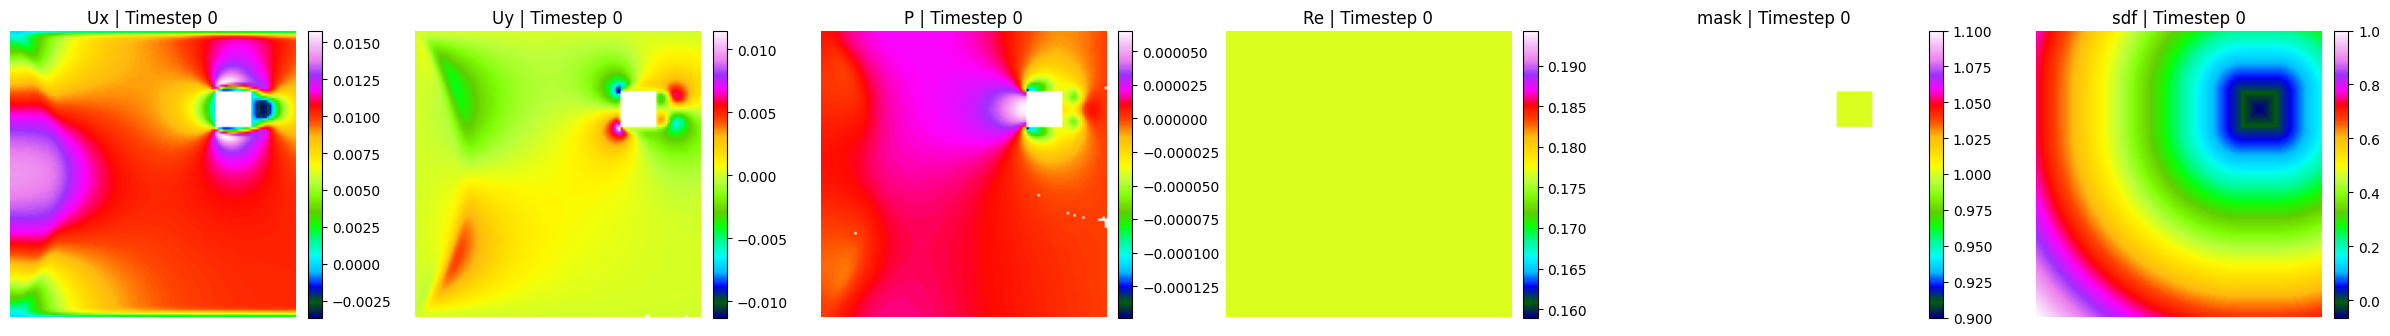

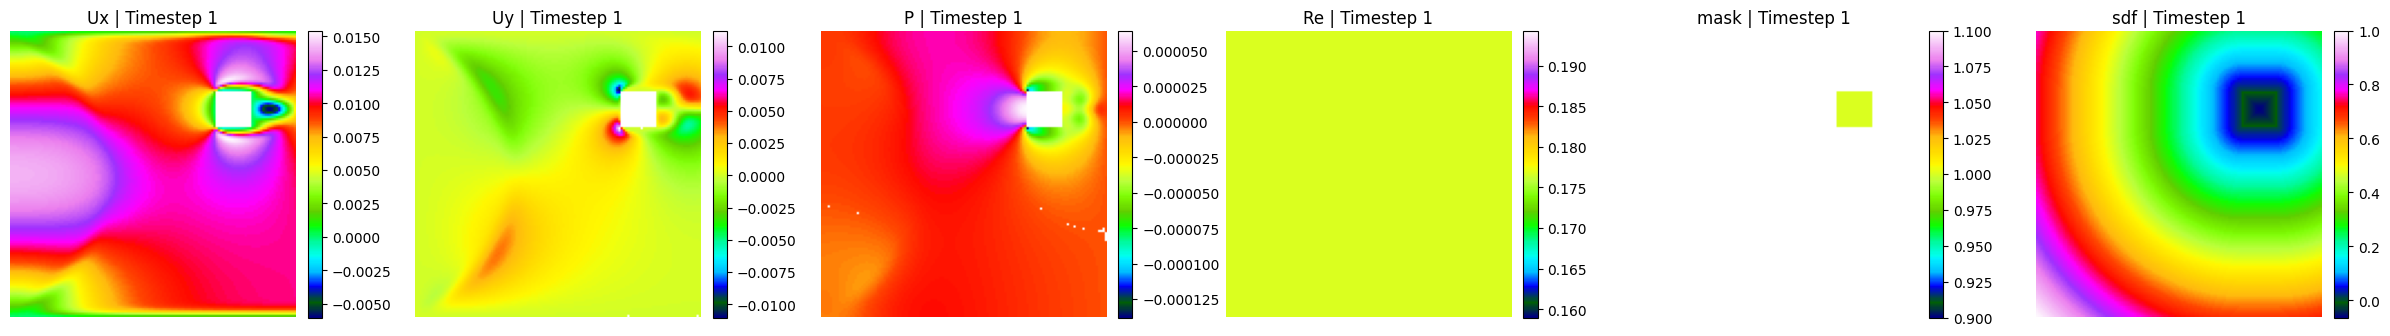

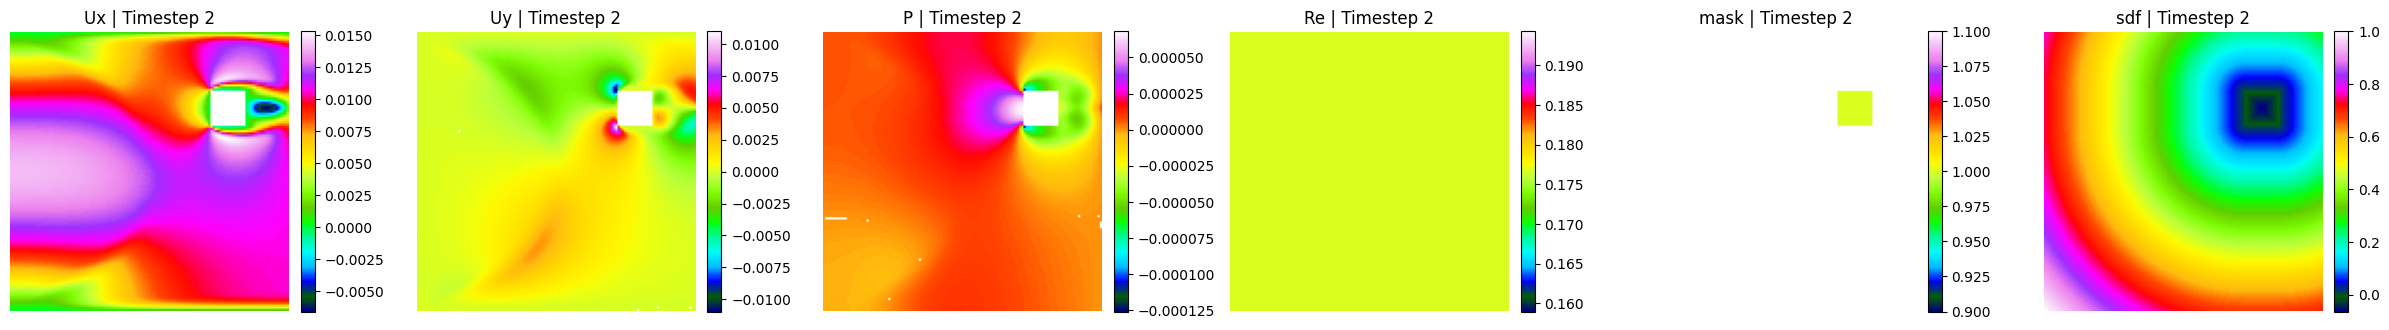

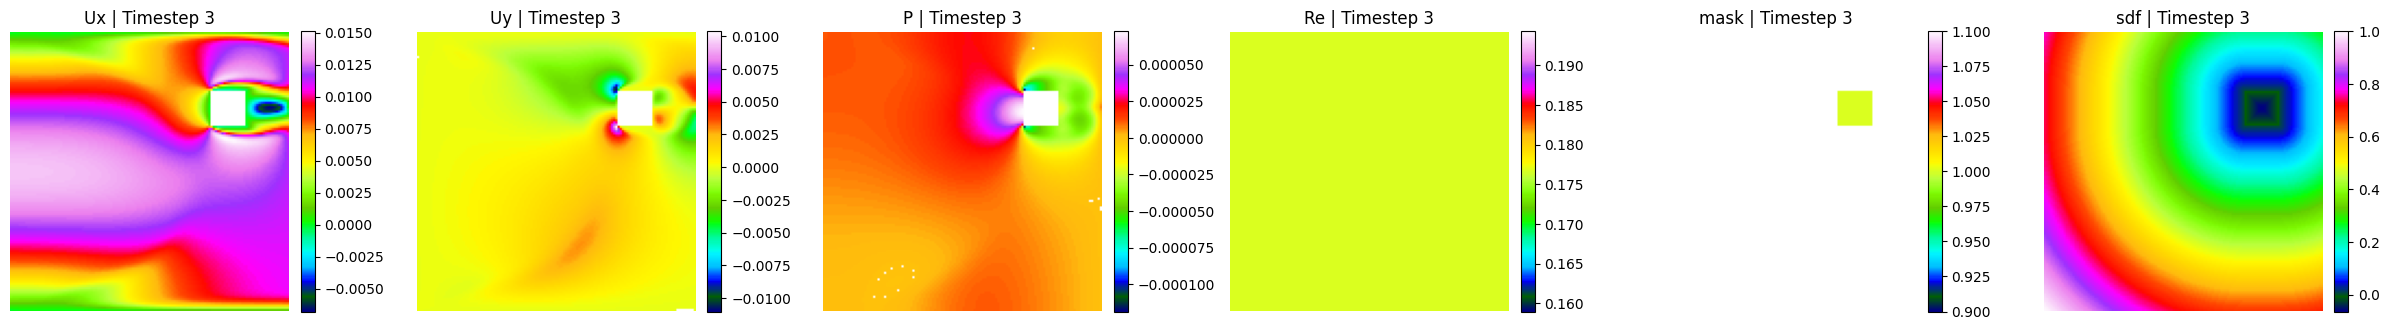

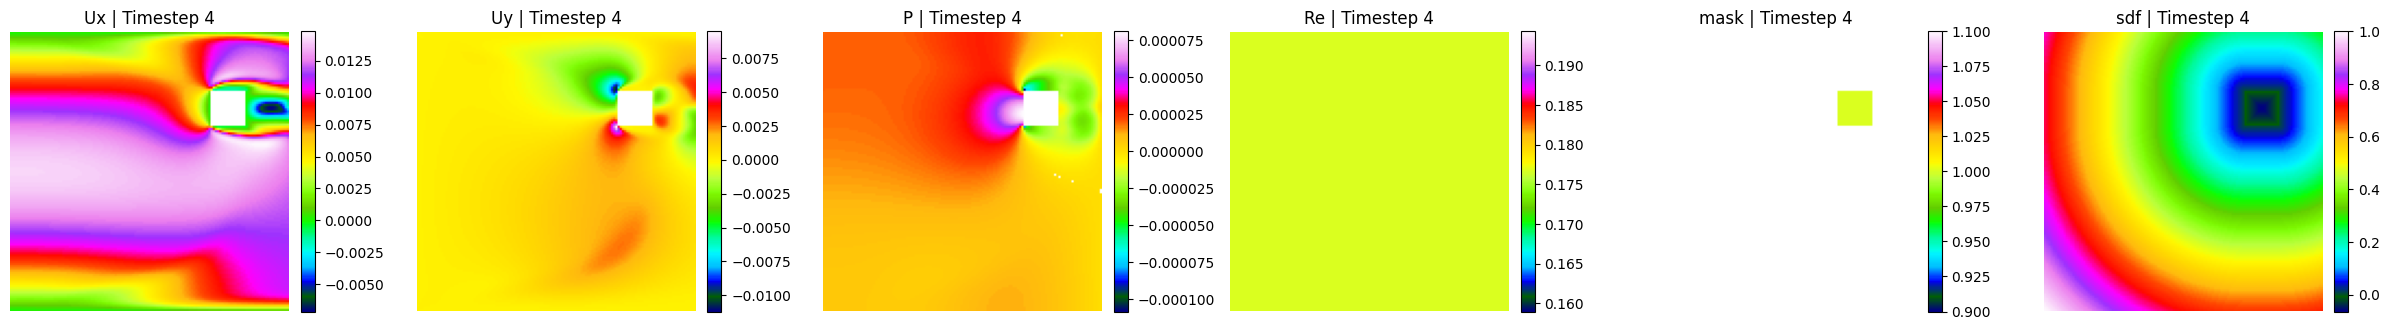

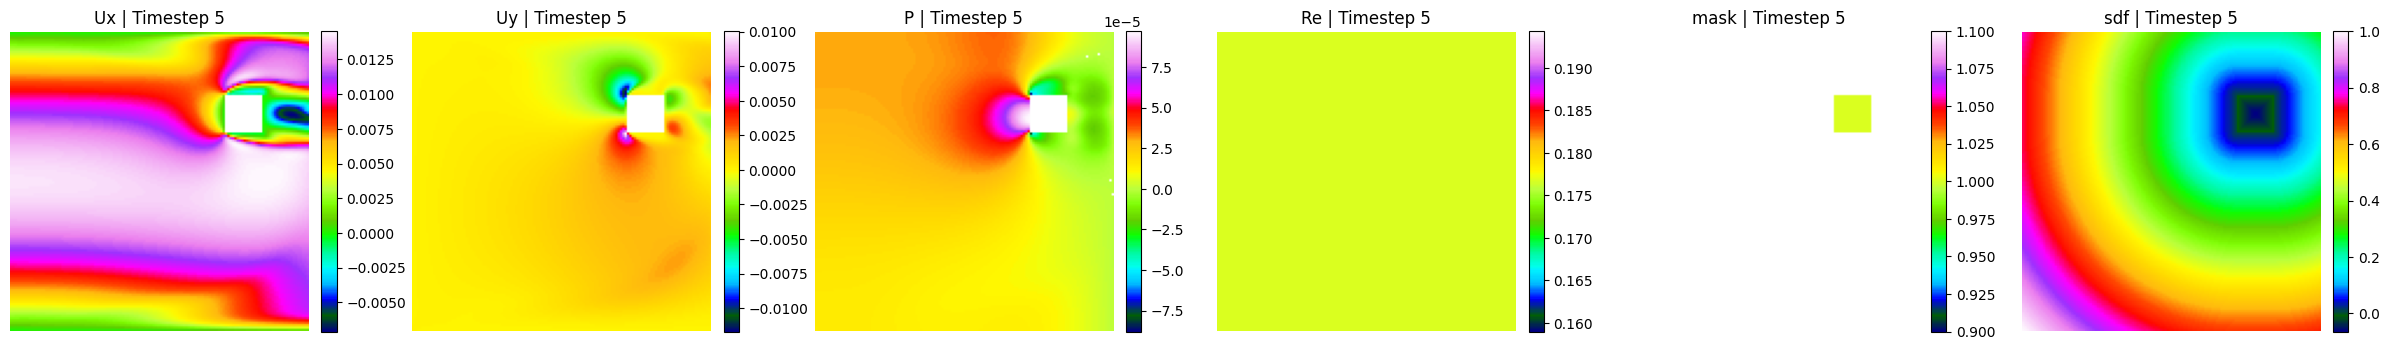

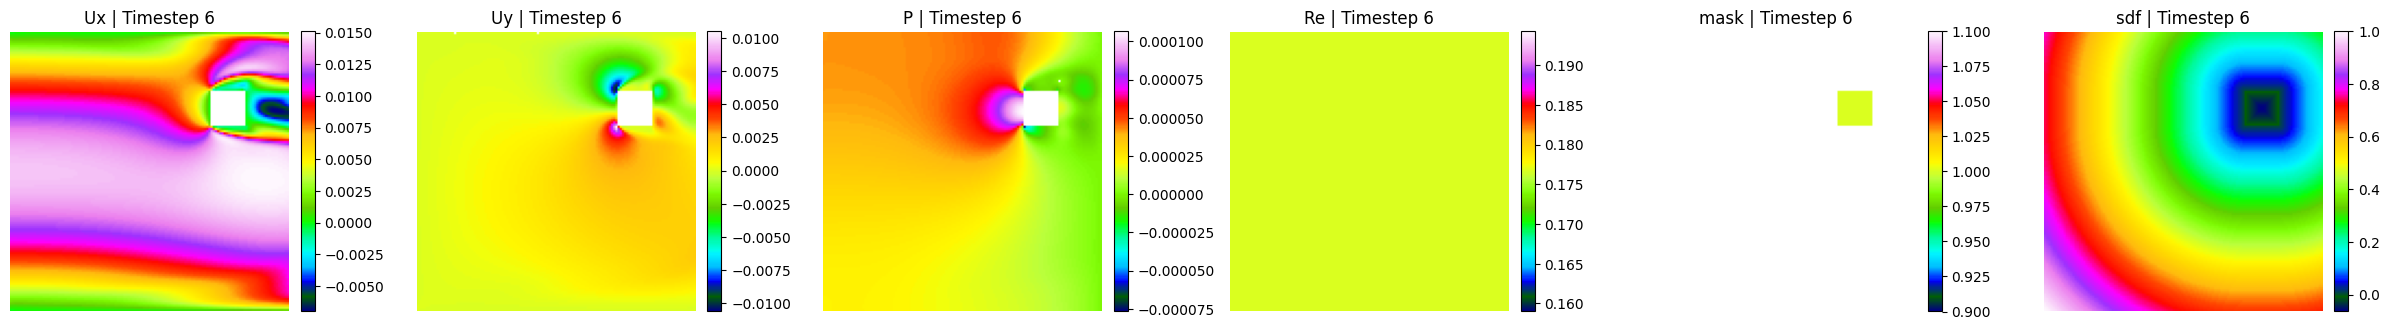

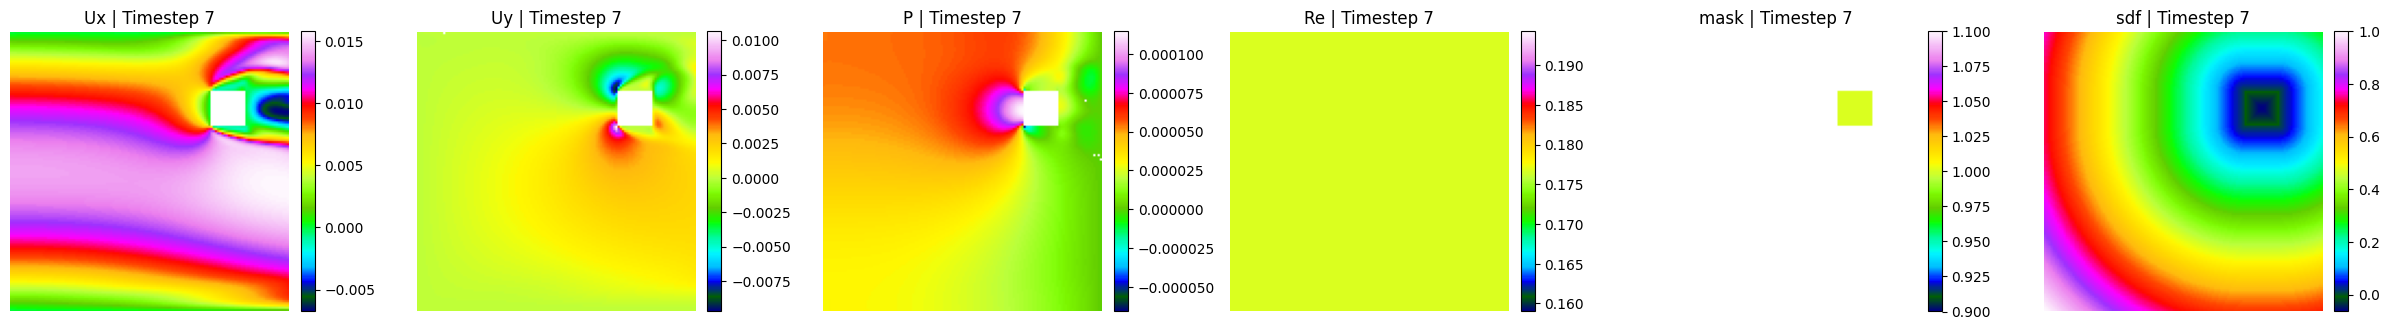

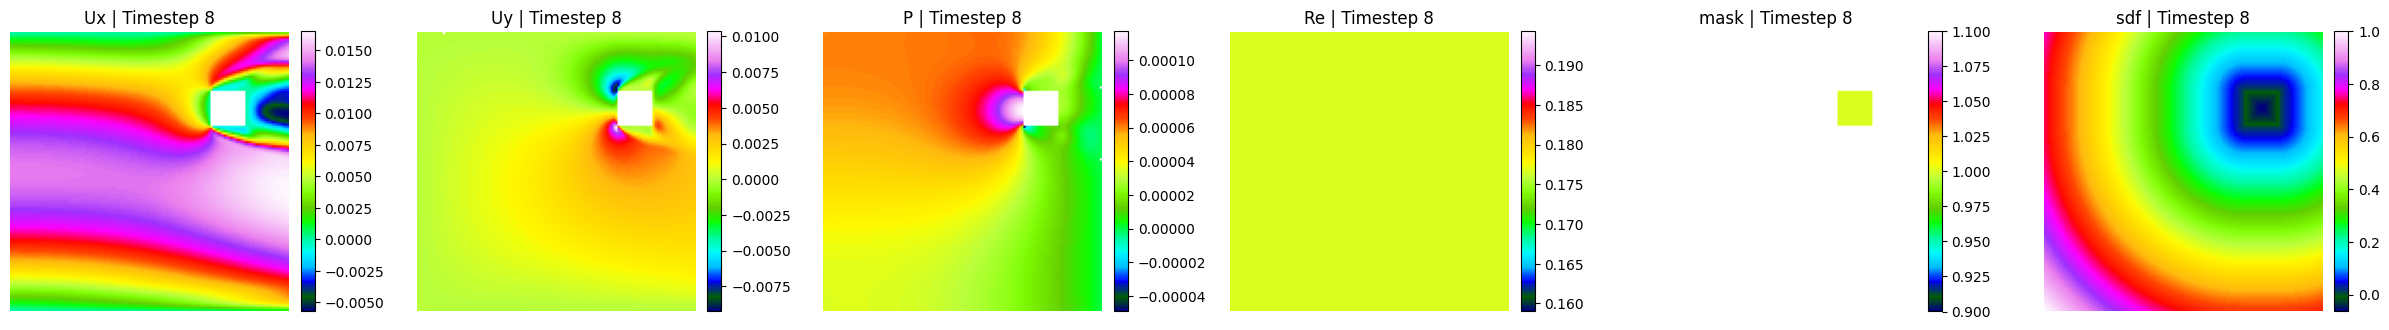

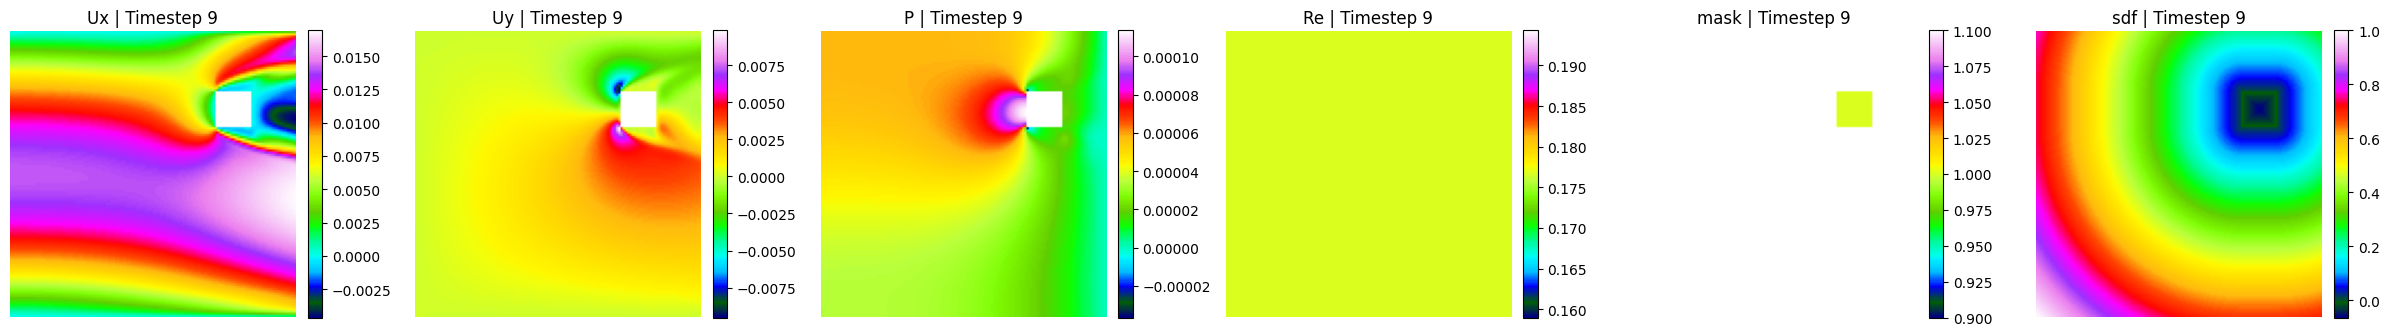

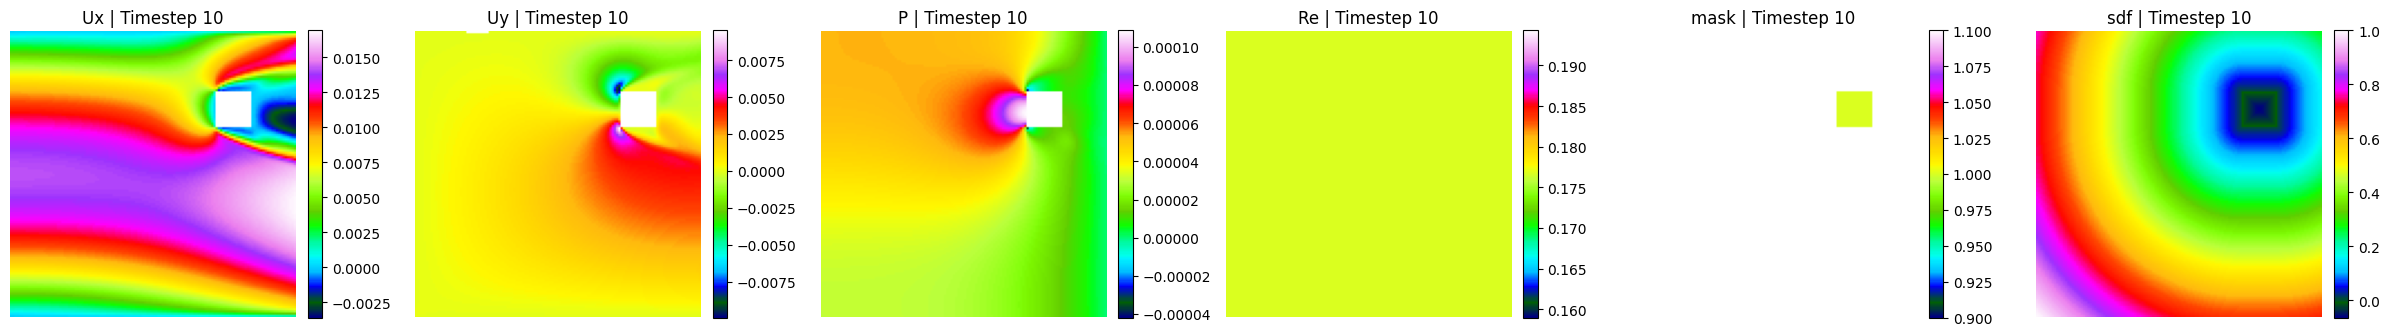

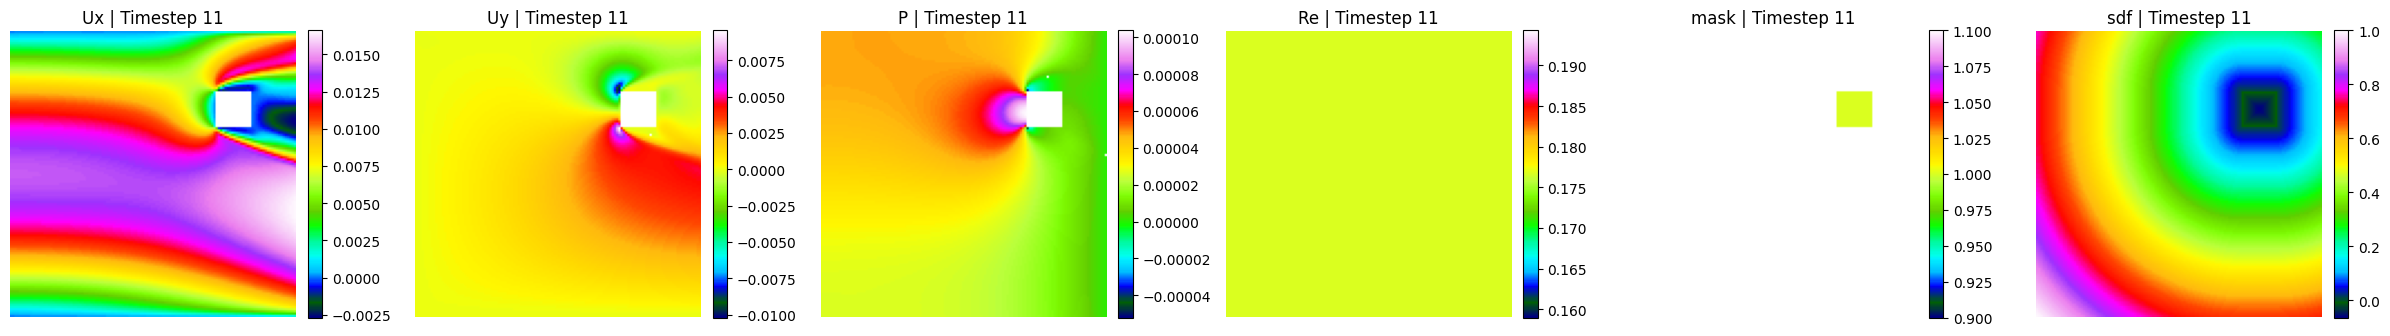

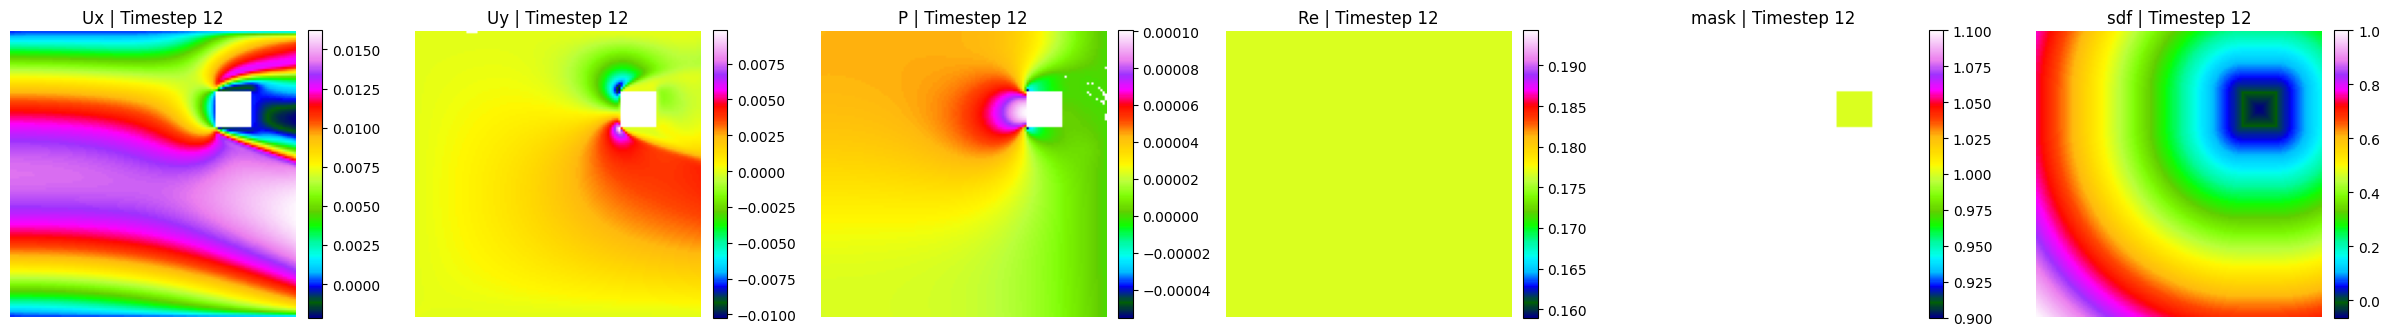

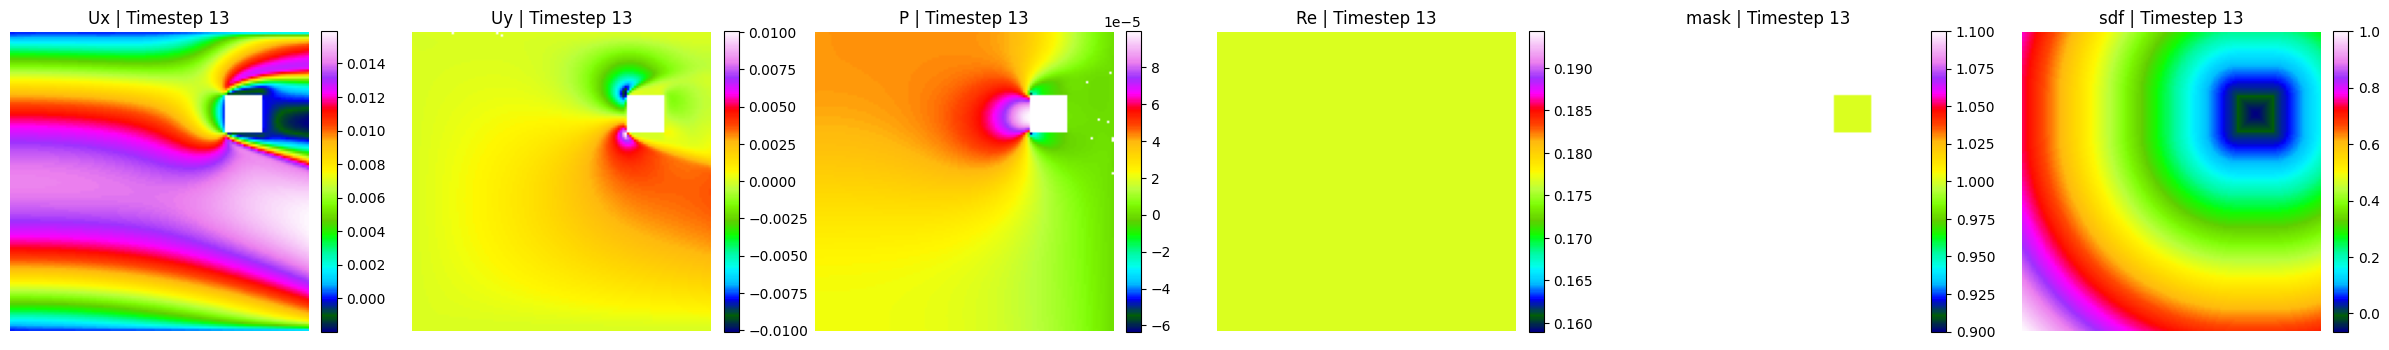

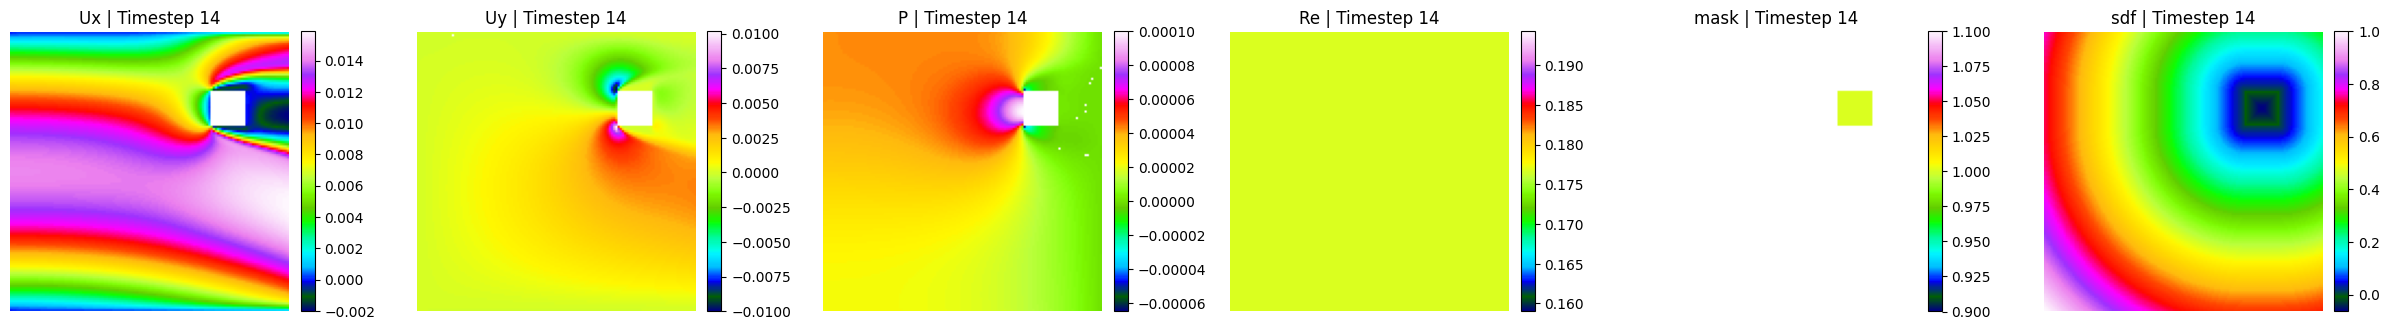

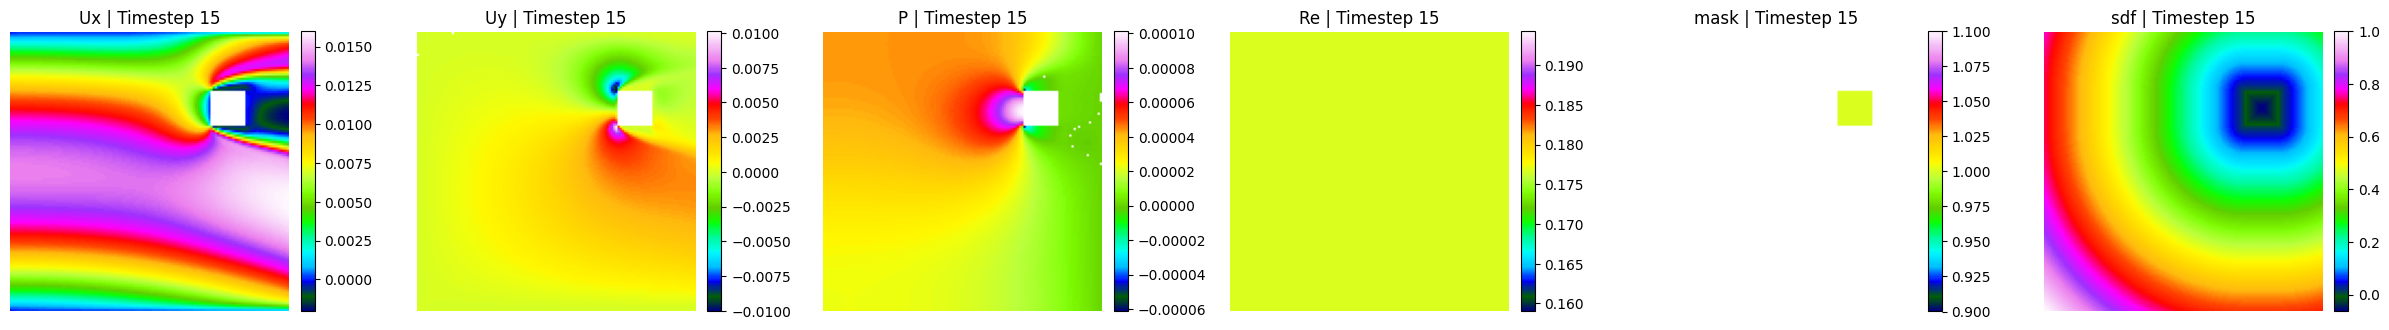

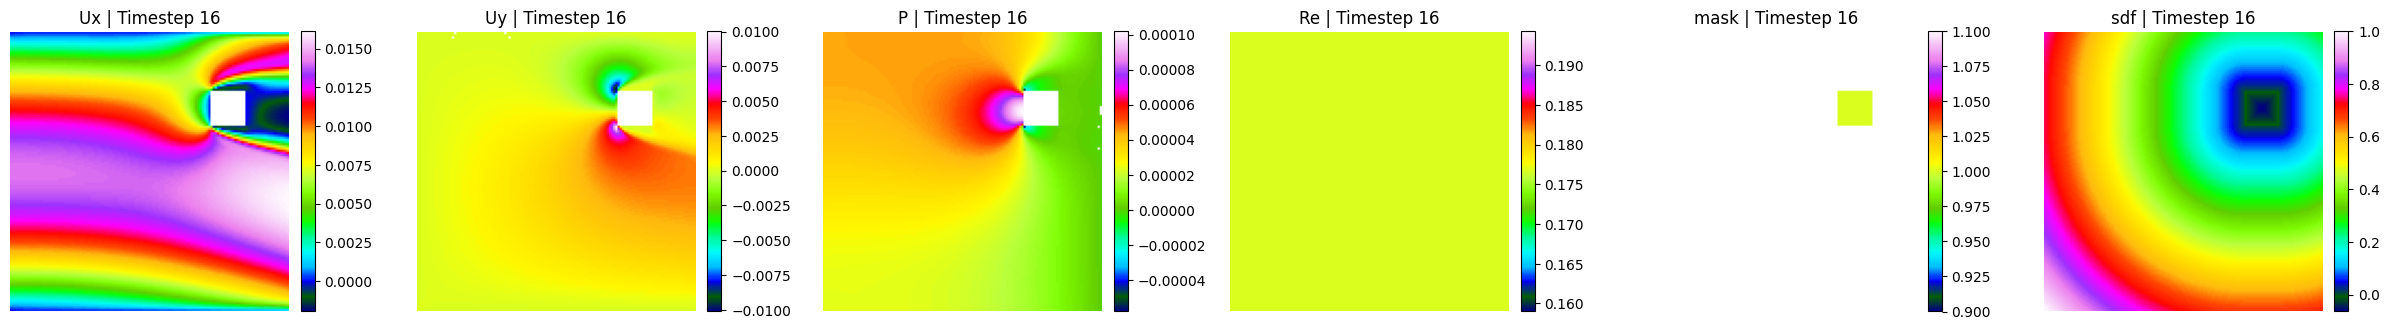

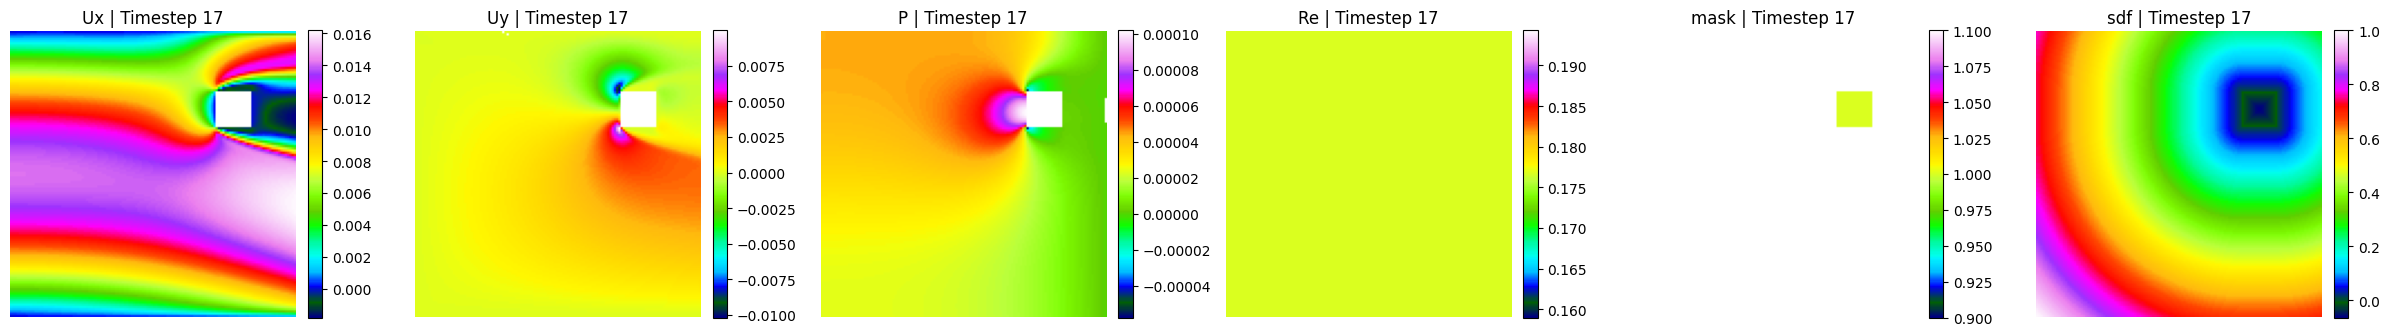

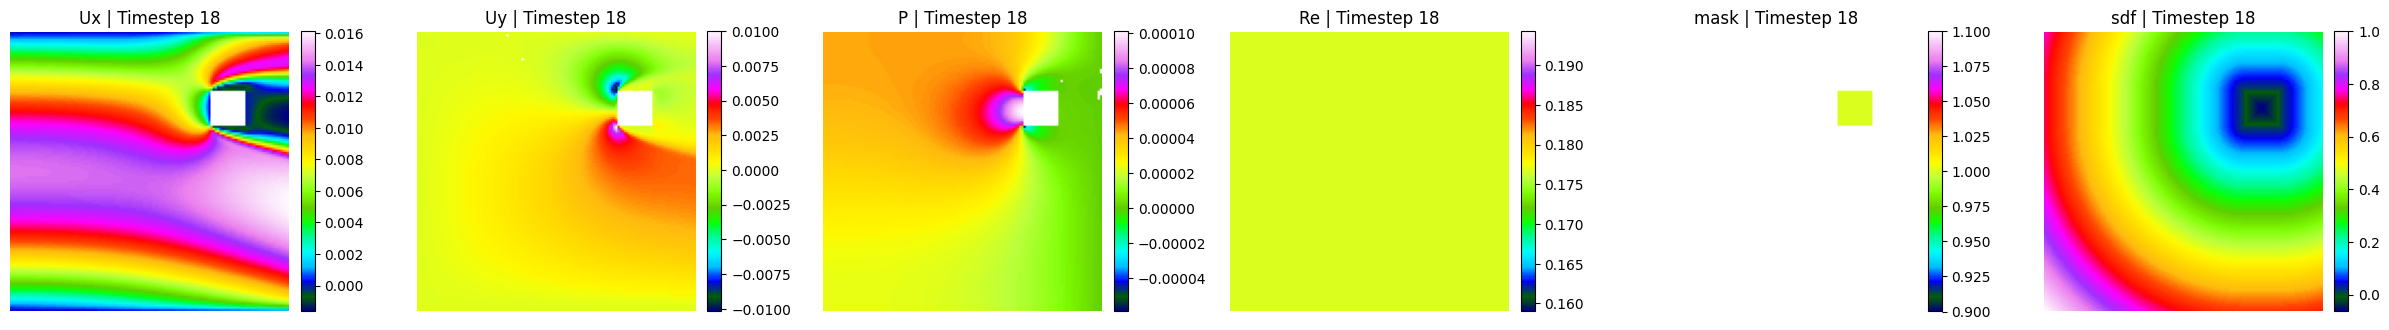

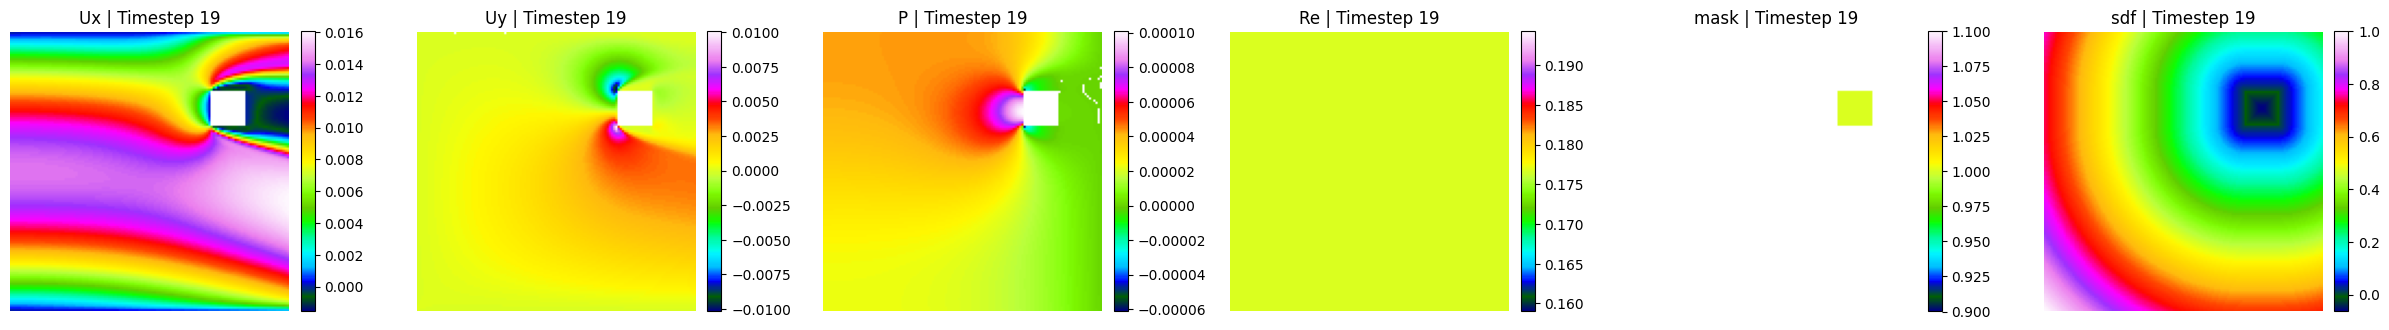

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
def plot_with_hole_white(
    trajectory, 
    channel_names=["Ux", "Uy", "P", "Re", "mask", "sdf"], 
    tol=1e-8
):
    """
    Plot each timestep of a trajectory such that values whose absolute value
    is below a given tolerance are displayed as white (masked).
    """
    cmap = matplotlib.cm.get_cmap('gist_ncar').copy()
    cmap.set_bad(color='white')

    n_timesteps = trajectory.shape[0]
    for t in range(n_timesteps):
        data = trajectory[t]
        n_channels = data.shape[-1]
        
        fig, axes = plt.subplots(1, n_channels, figsize=(4*n_channels, 4))
        for ch in range(n_channels):
            masked_channel = np.ma.masked_where(np.abs(data[:, :, ch]) < tol, data[:, :, ch])
            valid_vals = data[:, :, ch][np.abs(data[:, :, ch]) >= tol]
            if valid_vals.size > 0:
                vmin, vmax = valid_vals.min(), valid_vals.max()
            else:
                vmin, vmax = 0, 1
            im = axes[ch].imshow(masked_channel, cmap=cmap, vmin=vmin, vmax=vmax)
            axes[ch].set_title(f"{channel_names[ch]} | Timestep {t}")
            axes[ch].axis("off")
            fig.colorbar(im, ax=axes[ch], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

data = np.load("/data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/FPO_Hole_Location_normalised_10240.npy", mmap_mode='r', allow_pickle=True)
trajectory = data[512]
plot_with_hole_white(trajectory)

In [12]:
data = np.load("/data/group_data/sage_lab_complex_geometry/misha_data/FPO_Cylinder_Hole_Location/FPO_Hole_Location_normalised_10240.npy", mmap_mode='r')
print(data.shape)

(10240, 20, 128, 128, 6)
